# Start

In [1]:
import pandas as pd
from scipy.stats import pearsonr
import numpy as np
import re
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib as mpl
import pickle
from scipy import stats
pd.set_option('display.max_rows',2000)
import seaborn as sns
from sklearn import linear_model
from sklearn import metrics
import math
from PIL import Image
from io import BytesIO
import matplotlib.gridspec as gridspec


In [2]:
# to find best correlation:
# 1. calculated the mean 10ms power and 10ms rate 
# 2. shift 10 ms rate rows between range of 0 to 500 (i.e 0 second to 5 seconds)
# 2. After dropping, calculate the mean power of 500 ms and rate for 500 ms
# 3. Calculate correlation for each shift and find maximum correlation and respective shift
# 4. Shift the dataframe by max amount.
# 5. Repeate for all files

#  Select 2 or 0 digits for a decimal number

In [3]:
def keep_digits(x,i):
    x = float(x[:x.find('.')+i])
    return x

#  power per 10ms


In [4]:
def get_attack_power_10ms(device,port_state,scenario,attack_th,attack_type,reading_numb):
    
    # Read attack file
    file_loc1    = '/home/ydalal/media/bhagyashri/%s/%s/power/%s/%s%s%sp%s.txt'%(device,port_state,scenario,device,attack_type,attack_th,reading_numb)
    df1           = pd.read_csv(file_loc1,sep='\t',names=['index','timeSec','nanosecond','dontcare','voltageVolt','milliampCurrent'], low_memory=False)
    df1['power']  = df1['voltageVolt'] * df1['milliampCurrent'] 
    
    # Divide nanosecond by 1000,000,000
    df1['nanosecond'] = df1['nanosecond']/1000000000
    # # Get absolute time (0,1,2,.....,179,180)    
    df1['timeSecAbs'] =  df1['timeSec'] - df1.timeSec.min()

    # # Add seconds to nanosecond
    df1['nanosecond']   = df1['timeSecAbs'] + df1['nanosecond']

    # # # convert datatype
    df1['nanosecond'] = df1['nanosecond'].astype(str)
    df1['nanosecond']=df1['nanosecond'].apply(lambda x: keep_digits(x,3))

    # # # one row is mean of 10 ms
    df_ms_attack_power = df1[['nanosecond','power']].groupby(by=['nanosecond']).mean().reset_index()
    df_ms_attack_power.columns = ['nanosecond','power_attack']

    return df_ms_attack_power

# Attack_Rate per 10ms

In [5]:
#%%writefile rate_ms.py
# find rate per 500ms
# return dataframe with rate per 500ms

def get_attack_rate_10ms(device,port_state,scenario,attack_th,attack_type,reading_numb):
    out_name  = device+attack_type+str(attack_th)+'out'+str(reading_numb)
    file_path = '/home/ydalal/media/bhagyashri/%s/%s/out/%s/csv1/%s.csv'%(device,port_state,scenario,out_name)
    df        = pd.read_csv(file_path,sep='\t',names=['packets','time','ipSrc','ipDst'], low_memory=False)
    df.drop(df.index[0], inplace=True)
    ## to find rate for per 10 ms 

    df['time'] = df['time'].astype(str)
    df['time'] = df['time'].apply(lambda x: keep_digits(x,3))
    
    if (attack_type == 'udp' and port_state == 'a_tcp_close_udp_close'):
        
        df['ipDst'] = df['ipDst'].astype(str)
        df['ipDst_list'] = df['ipDst'].apply(lambda x: x.split(","))
        df['ipDst_count'] = df.apply(lambda x: len(x['ipDst_list']), axis=1)
        df['ipDst'] = df.apply(lambda x: x['ipDst'] if x['ipDst_count'] == 1 else x['ipDst_list'][0], axis=1)

        del df['ipDst_list']
        del df['ipDst_count']
        
        df['ipSrc'] = df['ipSrc'].astype(str)
        df['ipSrc_list'] = df['ipSrc'].apply(lambda x: x.split(","))
        df['ipSrc_count'] = df.apply(lambda x: len(x['ipSrc_list']), axis=1)
        df['ipSrc'] = df.apply(lambda x: x['ipSrc'] if x['ipSrc_count'] == 1 else x['ipSrc_list'][0], axis=1)

        del df['ipSrc_list']
        del df['ipSrc_count']
        
        
    # rate for per 10 ms
    df_ms_attack   = df[['time','ipDst']].groupby(by=['time'])['ipDst'].apply(lambda x:x[x.str.contains('192.168.1.245', na=False)].count()).to_frame('attack_rate').reset_index()

    #print (df_ms_packet_rate.shape)
    return df_ms_attack

#  attack and power per 10ms

In [6]:
def get_rate_power_10ms(device,port_state,scenario,attack_th,attack_type,reading_numb):
    
    df_ms_power  = get_attack_power_10ms(device,port_state,scenario,attack_th,attack_type,reading_numb)
    df_ms_rate   = get_attack_rate_10ms(device,port_state,scenario,attack_th,attack_type,reading_numb)
    df_ms_merged = pd.merge(df_ms_power,df_ms_rate,left_on=['nanosecond'],
                                                            right_on=['time'],
                                                            how='inner')
    return df_ms_merged

# attack and power per 1 sec

In [7]:
def get_attack_power_sec(df_ms_merged):
              
    # Since out of 1 second interval the shift is for x ms, the 1sec interval rate and power will have 
    # small value becasue not complete.
    idle_power = 556.827584196
    
    df_sec_power = df_ms_merged[['nanosecond', 'power_attack']].copy(deep=True)
    df_sec_power['nanosecond'] = df_sec_power['nanosecond'].astype(str)
    df_sec_power['nanosecond'] =  df_sec_power['nanosecond'].apply(lambda x: keep_digits(x,1))
    df_sec_power = df_sec_power[['nanosecond','power_attack']].groupby(by=['nanosecond']).mean().reset_index()

    df_sec_power['power_perc_chng'] = ((df_sec_power['power_attack'] -idle_power)/ idle_power)*100

    df_sec_rate = df_ms_merged[['time','attack_rate']].copy(deep=True)
    df_sec_rate['time'] = df_sec_rate['time'].astype(str)
    df_sec_rate['time'] =  df_sec_rate['time'].apply(lambda x: keep_digits(x,1))

    df_sec_rate = df_sec_rate[['time','attack_rate']].groupby(by=['time']).sum().reset_index()

    df_sec_merged = pd.merge(df_sec_power,df_sec_rate,left_on=['nanosecond'],right_on=['time'],how='inner')
    
    return df_sec_merged


# attack and power per 500 ms

In [7]:
def get_attack_power_500ms(df_ms_merged):
              
    # Since out of 1 second interval the shift is for x ms, the 1sec interval rate and power will have 
    # small value becasue not complete.
    idle_power = 556.827584196
    frames = []
    rows   = []
    
    
    df_500ms_power = df_ms_merged[['nanosecond', 'power_attack']].copy(deep=True)
    df_500ms_power['nanosecond'] = df_500ms_power['nanosecond'].astype(str)
    df_500ms_power['nanosecond'] =  df_500ms_power['nanosecond'].apply(lambda x: keep_digits(x,1))

    for i in df_500ms_power.nanosecond.unique():
        df = df_500ms_power[df_500ms_power['nanosecond']== i]
        center_index = int (df.shape[0]/2)
        if center_index == 0:
            center_index=1

        power_mean_per_500ms = df[:center_index]['power_attack'].mean()
        frames.append([i,power_mean_per_500ms])

        power_mean_per_500ms = df[center_index:]['power_attack'].mean()
        frames.append([i+0.500,power_mean_per_500ms])

    df_500ms_power = pd.DataFrame(frames,columns=['nanosecond','power_attack'])
    df_500ms_power = df_500ms_power.dropna()
    df_500ms_power['power_perc_chng'] = ((df_500ms_power['power_attack'] - idle_power)/idle_power)*100


    df_500ms_rate = df_ms_merged[['time','attack_rate']].copy(deep=True)
    df_500ms_rate['time'] = df_500ms_rate['time'].astype(str)
    df_500ms_rate['time'] =  df_500ms_rate['time'].apply(lambda x: keep_digits(x,1))

    for i in df_500ms_rate.time.unique():
        df = df_500ms_rate[df_500ms_rate['time']==i]
        center_index = int (df.shape[0]/2)
        if center_index == 0:
            center_index=1
        rate_count_per_500ms = df[:center_index]['attack_rate'].sum()
        rows.append([i,rate_count_per_500ms])

        rate_count_per_500ms = df[center_index:]['attack_rate'].sum()
        rows.append([i+0.500,rate_count_per_500ms])

    df_500ms_rate = pd.DataFrame(rows,columns=['time','attack_rate'])

    df_500ms_merged = pd.merge(df_500ms_power,df_500ms_rate,left_on=['nanosecond'],right_on=['time'],how='inner')
    
    return df_500ms_merged


# attack and power per 1.5 sec

In [20]:
def get_attack_powe_one_half_sec(df_ms_merged):    
    
    
    
    idle_power = 556.827584196
    N = 1.5

    df_ms_merged['one_half_sec'] = df_ms_merged.nanosecond//N
    df_one_half_sec = df_ms_merged.groupby(df_ms_merged.nanosecond//N,as_index=False).agg({'one_half_sec':'mean','time':'mean','nanosecond': 'mean','power_attack': 'mean','attack_rate':'sum'})
    df_one_half_sec['power_perc_chng'] = ((df_one_half_sec['power_attack'] - idle_power)/idle_power)*100
    
    return df_one_half_sec

# Find correlation cofficient for attack_rate and power

In [19]:
def find_corr(df_ms_merged1):
    
    corr_arr =[]
    for i in range (0,500,1):
        # copy dataframe
        df_ms_merged = df_ms_merged1.copy(deep=True)
        # shift by i ms
        df_ms_merged['attack_rate'] = df_ms_merged['attack_rate'].shift(i)
        df_ms_merged = df_ms_merged.dropna()

        #start time from zero after drop
        df_ms_merged['nanosecond'] =  df_ms_merged['nanosecond'] - df_ms_merged.nanosecond.min()
        df_ms_merged['time'] =  df_ms_merged['time'] - df_ms_merged.time.min()
        

        df_500ms_merged  = get_attack_power_500ms(df_ms_merged)
#         df_sec_merged  = get_attack_power_sec(df_ms_merged)
#         df_sec_merged  = get_attack_powe_one_half_sec(df_ms_merged)
        
        corr = stats.pearsonr(df_500ms_merged['attack_rate'],df_500ms_merged['power_attack'])[0]
#         print ("corr for shift" + " "+ str(i)+" is: " +str(corr))
        corr_arr.append((corr,i))

    x=np.argmax(corr_arr, axis=0)
    return corr_arr[x[0]]

# save max corr

In [20]:
#%%writefile dict_power_rate.py
from variables import *

port_states = ['a_tcp_filter_udp_filter']


shift_value   = 0

for port_state in ['a_tcp_filter_udp_filter']:
    
    if port_state == 'a_tcp_filter_udp_filter':
        attack_types = ['udp']
    else:
        attack_types = ['tcp','udp']

    for attack_type in attack_types:
        for scenario in ['scen3']:
            if port_state == 'a_tcp_filter_udp_filter' and (scenario == 'scen1' or scenario == 'scen2'):
                fileCount = 10
            else:
                fileCount = 5
            for attack_th in attack_ths:
                for reading_numb in range (0,fileCount):
                    try:
                        # find per 10ms 
                        df_out_ms_merged = get_rate_power_10ms(device,port_state,scenario,attack_th,attack_type,reading_numb)
                        #find max correlation
                        shift_value      = find_corr(df_out_ms_merged)
                        # NAME of file
                        key = str(device)+'_'+str(scenario)+'_'+str(attack_th)+'_'+str(attack_type)+'_'+str(reading_numb)

                        shift_value = list(shift_value)
                        shift_value.append(key)
                        shift_value = tuple(shift_value)
                        print (shift_value)
#                         save max corr, shift and file name
                        csv_file_name2 = '/home/ydalal/media/bhagyashri/%s/%s/df_corr_500ms/%s/%s%scorr.csv'%(device,port_state,scenario,device,attack_type)           
#                         csv_file_name2 = '/home/ydalal/media/bhagyashri/%s/%s/df_corr/%s/%s%scorr.csv'%(device,port_state,scenario,device,attack_type)           

                        corr_file =  open(csv_file_name2 ,'ab')
                        np.savetxt(corr_file,[shift_value],delimiter=",",fmt="%s")
                        corr_file.close() 

                    except Exception as e:
                        print(e)
                        continue
                    

(0.2055773046773008, 67, 'a_scen3_0.5_udp_0')
(0.008850989630546207, 407, 'a_scen3_0.5_udp_1')
(0.21220126330323164, 111, 'a_scen3_0.5_udp_2')
(0.17862329537080038, 466, 'a_scen3_0.5_udp_3')
(0.07808661427894001, 115, 'a_scen3_0.5_udp_4')
(0.13436861305118922, 155, 'a_scen3_1_udp_0')
(0.14970530574299462, 231, 'a_scen3_1_udp_1')
(0.19444517856307403, 2, 'a_scen3_1_udp_2')
(0.05719685257654995, 87, 'a_scen3_1_udp_3')
(0.2211664710521412, 170, 'a_scen3_1_udp_4')
(0.010830690283299457, 45, 'a_scen3_2_udp_0')
(-0.0988945910155549, 354, 'a_scen3_2_udp_1')
(-0.019724273180382744, 22, 'a_scen3_2_udp_2')
(-0.0032744134473823546, 421, 'a_scen3_2_udp_3')
(0.13201063484439476, 100, 'a_scen3_2_udp_4')
(0.12956751760749843, 87, 'a_scen3_4_udp_0')
(0.10706388199039923, 112, 'a_scen3_4_udp_1')
(0.01649310807433807, 446, 'a_scen3_4_udp_2')
(0.16373667424971994, 484, 'a_scen3_4_udp_3')
(0.2016448530184752, 437, 'a_scen3_4_udp_4')
(0.04112534753053339, 126, 'a_scen3_6_udp_0')
(0.05787715975630253, 152, 

# Save the final file(power_change and rate)

In [11]:
#%%writefile plot_graph.py
from variables import *

i=0                                           # for different line style (colour and style) in graph
j=0                                           #for legend
k=97                                          #for a,b.... title of graph
n=0
p=0                                           # for scenarios since number of readings are different
r=0                                           # for attack names

port_states = ['a_tcp_filter_udp_filter','a_tcp_open_udp_open','a_tcp_close_udp_close']


for port_state in ['a_tcp_filter_udp_filter']:
    
    if port_state == 'a_tcp_filter_udp_filter':
        attack_types = ['udp']
    else:
        attack_types = ['udp']
    
    for attack_type in attack_types:
        
        for scenario in ['scen3']:
            
            if port_state == 'a_tcp_filter_udp_filter' and (scenario == 'scen1' or scenario == 'scen2'):
                fileCount = 10
            else:
                fileCount = 5
            csv_file_name2 = '/home/ydalal/media/bhagyashri/%s/%s/df_corr_500ms/%s/%s%scorr.csv'%(device,port_state,scenario,device,attack_type)           
#             csv_file_name2 = '/home/ydalal/media/bhagyashri/%s/%s/df_corr/%s/%s%scorr.csv'%(device,port_state,scenario,device,attack_type)           
#             csv_file_name2 = '/home/ydalal/media/bhagyashri/%s/%s/df_corr_one_half_sec/%s/%s%scorr.csv'%(device,port_state,scenario,device,attack_type)           

            df_corr        = pd.read_csv(csv_file_name2,sep=',',names=['corr_value','shift_value','file_name'], low_memory=False)

            for attack_th in attack_ths:
                row_index=0
                for reading_numb in range (0,fileCount):
                    try:
                        shift_value  = df_corr['shift_value'].values[row_index]
                        row_index    =  row_index +1

                        df_out_ms_merged = get_rate_power_10ms(device,port_state,scenario,attack_th,attack_type,reading_numb)
                        df_out_ms_merged['attack_rate'] = df_out_ms_merged['attack_rate'].shift(shift_value)
                        df_out_ms_merged         = df_out_ms_merged.dropna()
                        #start time from zero after drop
                        df_out_ms_merged['nanosecond'] =  df_out_ms_merged['nanosecond'] - df_out_ms_merged.nanosecond.min()
                        df_out_ms_merged['time'] =  df_out_ms_merged['time'] - df_out_ms_merged.time.min()

#                         df_out_merged = get_attack_power_sec(df_out_ms_merged)  
                        df_out_merged = get_attack_power_500ms(df_out_ms_merged)  

                        df_out_merged.drop(df_out_merged.tail(1).index,inplace=True) # drop last n rows

                        csv_file_name1 = device+attack_type+str(attack_th)+'out'+str(reading_numb)
                        csv_file_loc1  = '/home/ydalal/media/bhagyashri/%s/%s/df_rate_power_500ms/%s'%(device,port_state,scenario)
#                         csv_file_loc1  = '/home/ydalal/media/bhagyashri/%s/%s/df_rate_power/%s'%(device,port_state,scenario)
#                         csv_file_loc1  = '/home/ydalal/media/bhagyashri/%s/%s/df_rate_power_one_half_sec/%s'%(device,port_state,scenario)

                        df_out_merged.to_csv('%s/%s.csv'%(csv_file_loc1,csv_file_name1),index=False)  

                    except Exception as e:
                        print(e)
                        continue      

# fileCount

In [3]:
def a_tcp_filter_udp_filter_fileCount(scenario,attack_type,attack_th):
    
    if scenario == 'scen1' and attack_type == 'udp' and attack_th == 0.5:
                        fileCount = [0,1,2,3,4,5,6,9]
    elif scenario == 'scen1' and attack_type == 'udp' and attack_th == 1:
            fileCount = [0,1,2,3,4,5,6,9]
    elif scenario == 'scen1' and attack_type == 'udp' and attack_th == 2:
            fileCount = [0,1,2,3,4,5,7,8]
    elif scenario == 'scen1' and attack_type == 'udp' and attack_th == 4:
            fileCount = [0,1,2,3,4,6,7,8,9]
    elif scenario == 'scen1' and attack_type == 'udp' and attack_th == 6:
            fileCount = [0,2,3,4,5,6,9]
    elif scenario == 'scen1' and attack_type == 'udp' and attack_th == 8:
            fileCount = [0,1,2,3,4,6,7,8,9]
    elif scenario == 'scen1' and attack_type == 'udp' and attack_th == 10:
            fileCount = [1,2,3,4,5,6,7,9]


    elif scenario == 'scen2' and attack_type == 'udp' and attack_th == 0.5:
            fileCount = [3,4,5,6,7,9]
    elif scenario == 'scen2' and attack_type == 'udp' and attack_th == 1:
            fileCount = [0,3,4,5,7,8,9]

    elif scenario == 'scen2' and attack_type == 'udp' and attack_th == 2:
            fileCount = [1,3,4,5,6,7,8]

    elif scenario == 'scen2' and attack_type == 'udp' and attack_th == 4:
            fileCount = [0,1,3,4,5,6,7,8]

    elif scenario == 'scen2' and attack_type == 'udp' and attack_th == 6:
            fileCount = [0,1,2,3,4,5,6,7,8,9]

    elif scenario == 'scen2' and attack_type == 'udp' and attack_th == 8:
            fileCount = [0,1,2,4,6,7,9]

    elif scenario == 'scen2' and attack_type == 'udp' and attack_th == 10:
            fileCount = [0,1,2,3,4,5,6,7,8,9]


    elif scenario == 'scen3' and attack_type == 'udp' and attack_th == 0.5:
            fileCount = [0,1,2,3,4]
    elif scenario == 'scen3' and attack_type == 'udp' and attack_th == 1:
            fileCount = [0,1,2,4]

    elif scenario == 'scen3' and attack_type == 'udp' and attack_th == 2:
            fileCount = [0,3,4]

    elif scenario == 'scen3' and attack_type == 'udp' and attack_th == 4:
        fileCount = [0,1,2]

    elif scenario == 'scen3' and attack_type == 'udp' and attack_th == 6:
        fileCount = [0,1,3,4]

    elif scenario == 'scen3' and attack_type == 'udp' and attack_th == 8:
        fileCount = [0,1,2,3,4]

    elif scenario == 'scen3' and attack_type == 'udp' and attack_th == 10:
        fileCount = [0,2,3]


    elif scenario == 'scen4' and attack_type == 'udp' and attack_th == 0.5:
            fileCount = [0,1,2,3]
    elif scenario == 'scen4' and attack_type == 'udp' and attack_th == 1:
            fileCount = [1,2,3,4]

    elif scenario == 'scen4' and attack_type == 'udp' and attack_th == 2:
            fileCount = [1,2,3,4]

    elif scenario == 'scen4' and attack_type == 'udp' and attack_th == 4:
            fileCount = [2,4]

    elif scenario == 'scen4' and attack_type == 'udp' and attack_th == 6:
            fileCount = [0,1,2,3,4]

    elif scenario == 'scen4' and attack_type == 'udp' and attack_th == 8:
            fileCount = [0,1,2,3,4]

    else :
            fileCount = [0,2,4]
    return fileCount


# Plot graph for all ports

[Errno 2] File b'/home/ydalal/media/bhagyashri/a/a_tcp_open_udp_open/df_rate_power_500ms/scen1/audp0.5out5.csv' does not exist: b'/home/ydalal/media/bhagyashri/a/a_tcp_open_udp_open/df_rate_power_500ms/scen1/audp0.5out5.csv'
[Errno 2] File b'/home/ydalal/media/bhagyashri/a/a_tcp_open_udp_open/df_rate_power_500ms/scen1/audp0.5out6.csv' does not exist: b'/home/ydalal/media/bhagyashri/a/a_tcp_open_udp_open/df_rate_power_500ms/scen1/audp0.5out6.csv'
[Errno 2] File b'/home/ydalal/media/bhagyashri/a/a_tcp_open_udp_open/df_rate_power_500ms/scen1/audp0.5out9.csv' does not exist: b'/home/ydalal/media/bhagyashri/a/a_tcp_open_udp_open/df_rate_power_500ms/scen1/audp0.5out9.csv'
[Errno 2] File b'/home/ydalal/media/bhagyashri/a/a_tcp_open_udp_open/df_rate_power_500ms/scen2/audp0.5out5.csv' does not exist: b'/home/ydalal/media/bhagyashri/a/a_tcp_open_udp_open/df_rate_power_500ms/scen2/audp0.5out5.csv'
[Errno 2] File b'/home/ydalal/media/bhagyashri/a/a_tcp_open_udp_open/df_rate_power_500ms/scen2/audp0

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


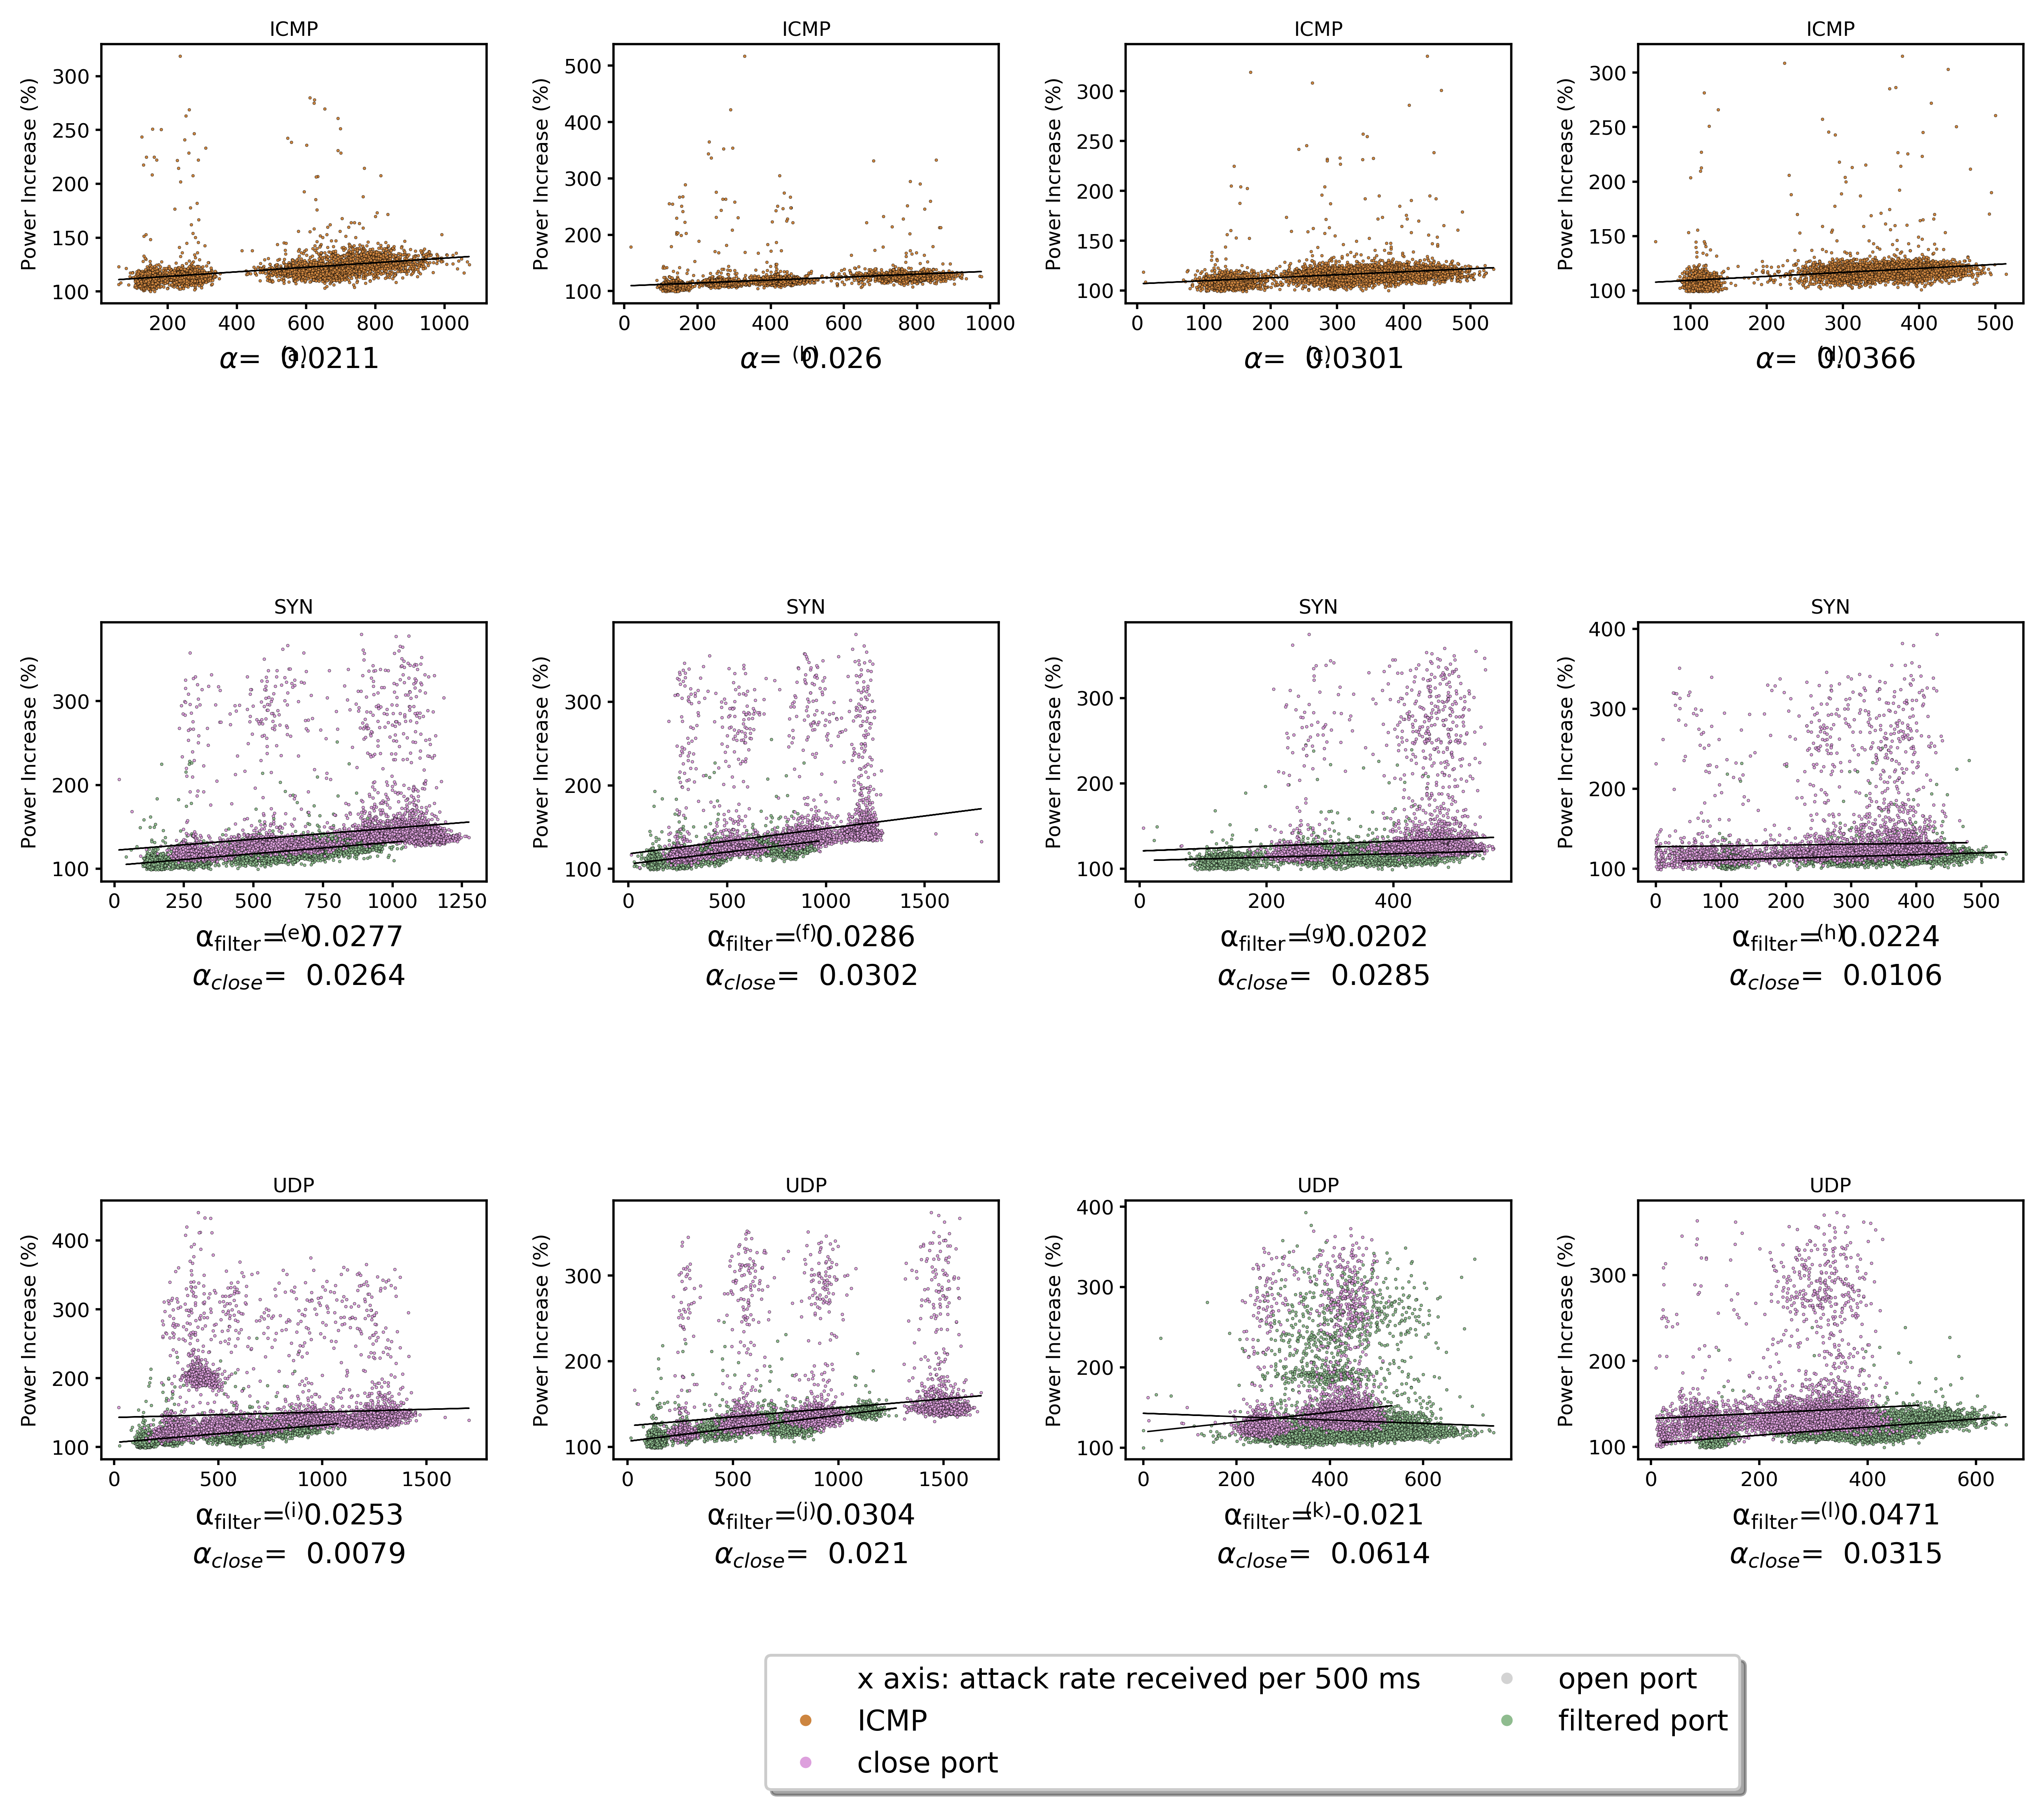

In [10]:
#%%writefile plot_graph.py
from variables import *
scen_line   = [mlines.Line2D([], [], linestyle='none',label='$P_L$,$R_7$')
 			  ,mlines.Line2D([], [], linestyle='none', label='$P_L$,$R_1$')
			  ,mlines.Line2D([], [],linestyle='none', label='$P_H$,$R_1$')
			  ,mlines.Line2D([], [],linestyle='none', label='$P_H$,$R_7$')]

label_type = ['$P_L$,$R_7$','$P_L$,$R_1$','$P_H$,$R_1$','$P_H$,$R_7$']

scen_line_tcp = [mlines.Line2D([], [],linestyle='none'),
                  mlines.Line2D([], [], linestyle='none',marker='.',color= 'grey'),
                  mlines.Line2D([], [],linestyle='none', marker='.',color= 'tan')]

scen_line_udp = [mlines.Line2D([], [],linestyle='none',label= label_type),
                  mlines.Line2D([], [], linestyle='none',marker='.',color= 'grey' ),
                  mlines.Line2D([], [],linestyle='none', marker='.',color= 'tan')]


legend_elements = [mlines.Line2D([], [], linestyle='none',label='x axis: attack rate received per 500 ms'),
                   mlines.Line2D([], [], linestyle='none',marker='.',color= 'peru',label="ICMP"),
                   mlines.Line2D([], [], linestyle='none',marker='.',color= 'plum',label="close port"),
                   mlines.Line2D([], [], linestyle='none',marker='.',color= 'lightgrey',label="open port"),
                   mlines.Line2D([], [], linestyle='none',marker='.',color= 'darkseagreen',label="filtered port"),

                  ]
power_label      = 100
powerstep_size   = 20
graph_rows       = 3
graph_cols       = 4
# fig_size         = (12,9)
pps_label1       = 2501     # for scen 1 and scen 2
pps_lebel2       = 1501     # for scen 1 and scen 2
pps_stepsize1    = 500      # for scen 3 and scen 4
pps_stepsize2    = 300      # for scen 3 and scen 4
graph_title      = ["ICMP","SYN","UDP"]
marker_array     = ["o", "o","o"]
marker_id        = 0
fig,axes   = plt.subplots(nrows=graph_rows, ncols=graph_cols, dpi=500, figsize=(10,8))
axes_list  = [item for sublist in axes for item in sublist] 
lm = linear_model.LinearRegression()
alpha_array = []
alpha_id    = 0
i=0                                           # for different line style (colour and style) in graph
j=0                                           #for legend
k=97                                          #for a,b.... title of graph
n=0
p=0                                           # for scenarios since number of readings are different
r=0                                           # for attack names




for attack_type in ['icmp','tcp','udp']:
    j=0
    i=0
    for scenario in scenarios:
        axs = axes_list.pop(0)
        x__=  []
        y__=  []
        x1__= []
        y1__= []
        x2__= []
        y2__= []
        port_state = 'a_tcp_filter_udp_filter'
        for attack_th in [0.5,1,2,4]:
            if port_state == 'a_tcp_filter_udp_filter':
                fileCount = a_tcp_filter_udp_filter_fileCount(scenario,attack_type,attack_th)
            else:
                fileCount = [0,1,2,3,4]
            for reading_numb in fileCount:
                try:
                    
                    port_state = 'a_tcp_filter_udp_filter'
                    csv_file_name1 = device+attack_type+str(attack_th)+'out'+str(reading_numb)
                    csv_file_loc1  = '/home/ydalal/media/bhagyashri/%s/%s/df_rate_power_500ms/%s/%s.csv'%(device,port_state,scenario,csv_file_name1)
                    df_out_merged  = pd.read_csv(csv_file_loc1,sep=',',names=['nanosecond','power_attack','power_perc_chng','time','attack_rate'], low_memory=False)
                    df_out_merged.drop(df_out_merged.index[0], inplace=True)
                    x__.extend(df_out_merged.attack_rate.values)
                    y__.extend(df_out_merged.power_perc_chng.values)
                    
                    if (attack_type=='tcp' or attack_type == 'udp'):
                        port_state     = "a_tcp_open_udp_open"
                        csv_file_loc2  = '/home/ydalal/media/bhagyashri/%s/%s/df_rate_power_500ms/%s/%s.csv'%(device,port_state,scenario,csv_file_name1)
                        df_out_merged1 = pd.read_csv(csv_file_loc2,sep=',',names=['nanosecond','power_attack','power_perc_chng','time','attack_rate'], low_memory=False)
                        df_out_merged1.drop(df_out_merged1.index[0], inplace=True)
                        x1__.extend(df_out_merged1.attack_rate.values)
                        y1__.extend(df_out_merged1.power_perc_chng.values)
                
                        
                        port_state = "a_tcp_close_udp_close"
                        csv_file_loc3    = '/home/ydalal/media/bhagyashri/%s/%s/df_rate_power_500ms/%s/%s.csv'%(device,port_state,scenario,csv_file_name1)
                        df_out_merged3 = pd.read_csv(csv_file_loc3,sep=',',names=['nanosecond','power_attack','power_perc_chng','time','attack_rate'], low_memory=False)
                        df_out_merged3.drop(df_out_merged3.index[0], inplace=True)
                        x2__.extend(df_out_merged3.attack_rate.values)
                        y2__.extend(df_out_merged3.power_perc_chng.values)
                        
                except Exception as e:
                    print(e)
                    continue
        
        x__=map(float, x__)
        y__=map(float, y__)  
        df = pd.DataFrame(zip(x__,y__),columns=['attack_rate','percntg_power_change'])
        df = df[df['percntg_power_change'] > 99]
        independent_variable_rate = df.attack_rate.values.reshape(-1,1)
        dependent_varaiable_power = df.percntg_power_change.values.reshape(-1,1)
        lm.fit(independent_variable_rate,dependent_varaiable_power)
        power_pred = lm.predict(independent_variable_rate)
        if attack_type == "icmp":
            axs.scatter(df['attack_rate'],df['percntg_power_change'],s=1,marker= marker_array[marker_id],facecolors='peru', edgecolors='k',linewidth = 0.1,alpha=1)
            axs.plot(df['attack_rate'], power_pred, color='black', linewidth=.5)
            a__         = lm.coef_[0]
            b__         = a__[0]
            alpha_array.append(round (b__,4)) 
            axs.set_xlabel ("("+ chr(k) + ")", fontsize=7)           
            axs.text(0.5,-0.25, r' $\alpha$= ' + " " +str(alpha_array[alpha_id]), size=10, ha="center", transform=axs.transAxes)
            alpha_id = alpha_id + 1
        else:
            axs.scatter(df['attack_rate'],df['percntg_power_change'],s=1,marker= marker_array[marker_id],facecolors='darkseagreen', edgecolors='k',linewidth = 0.1,alpha=1)
            axs.plot(df['attack_rate'], power_pred, color='black', linewidth=.5)
            a__         = lm.coef_[0]
            b__         = a__[0]
            alpha_array.append(round (b__,4)) 
            axs.set_xlabel ("("+ chr(k) + ")", fontsize=7)           
            axs.text(0.5,-0.25, r' $\mathrm{\alpha_{filter}}$= ' + " " +str(alpha_array[alpha_id]), size=10, ha="center", transform=axs.transAxes)
            alpha_id = alpha_id + 1
        
        if (attack_type=='tcp' or attack_type == 'udp'):
#             x1__=map(float, x1__)
#             y1__=map(float, y1__)  
#             df1 = pd.DataFrame(zip(x1__,y1__),columns=['attack_rate','percntg_power_change'])
#             df1 = df1[df1['percntg_power_change'] > 99]
#             independent_variable_rate1 = df1.attack_rate.values.reshape(-1,1)
#             dependent_varaiable_power1 = df1.percntg_power_change.values.reshape(-1,1)
#             lm.fit(independent_variable_rate1,dependent_varaiable_power1)
#             power_pred1 = lm.predict(independent_variable_rate1)
#             axs.scatter(df1['attack_rate'],df1['percntg_power_change'],s=1,marker= marker_array[marker_id],facecolors='lightgrey', edgecolors='k',linewidth = 0.1,alpha=1)
#             axs.plot(df1['attack_rate'], power_pred1, color='black', linewidth=.5)
#             a__         = lm.coef_[0]
#             b__         = a__[0]
#             alpha_array.append(round (b__,4)) 
#             axs.text(0.5,-0.33, r' $\alpha_{open}$= ' + " " +str(alpha_array[alpha_id]), size=10, ha="center", transform=axs.transAxes)
#             alpha_id = alpha_id + 1

            
            x2__=map(float, x2__)
            y2__=map(float, y2__)  
            df2 = pd.DataFrame(zip(x2__,y2__),columns=['attack_rate','percntg_power_change'])
            df2 = df2[df2['percntg_power_change'] > 99]
            independent_variable_rate2 = df2.attack_rate.values.reshape(-1,1)
            dependent_varaiable_power2 = df2.percntg_power_change.values.reshape(-1,1)
            lm.fit(independent_variable_rate2,dependent_varaiable_power2)
            power_pred2 = lm.predict(independent_variable_rate2)
            axs.scatter(df2['attack_rate'],df2['percntg_power_change'],s=1,marker= marker_array[marker_id],facecolors='plum', edgecolors='k',linewidth = 0.1,alpha=1)
            axs.plot(df2['attack_rate'], power_pred2, color='black', linewidth=.5)
            a__         = lm.coef_[0]
            b__         = a__[0]
            alpha_array.append(round (b__,4)) 
            axs.text(0.5,-0.4, r' $\alpha_{close}$= ' + " " +str(alpha_array[alpha_id]), size=10, ha="center", transform=axs.transAxes)
            alpha_id = alpha_id + 1

        axs.set_ylabel("Power Increase (%)", fontsize=7)
        axs.set_title(graph_title[n], fontsize=7,pad=3)
        axs.tick_params(right=False, top=False, labelsize=7,colors="k", length=2,pad=2)  #primary y and x
#         axs.set_yticks(np.arange(0,301, step = 100)) # primary y axis (bandwidth
#         axs.set_xticks(np.arange(0,1301, step = 400)) # 500ms
        #axs.set_xticks(np.arange(0,2501, step = 600)) # 1sec

#         if (attack_type=='tcp'):
#             axs.legend(scen_line_tcp,[label_type[i],'filtered port','open port'],ncol=1 , loc= 'upper right',borderpad= .5,fontsize = '7', frameon=False,numpoints=1)
        
#         elif (attack_type == 'udp'):
#             axs.legend(scen_line_udp,[label_type[i],'filtered port','open port'],ncol=1 , loc= 'upper right',borderpad= .5,fontsize = '7', frameon=False,numpoints=1)

#         else:
#             axs.legend(handles=[scen_line[i]],ncol=1, loc= 'upper right',borderpad= .5,fontsize = '7', frameon=False,numpoints=1)

#         if ((attack_type == 'icmp') and (scenario == 'scen1' or scenario == 'scen2')):
#             axs.set_xticks(np.arange(0,2401, step = 600))
        
#         elif ((attack_type == 'icmp') and (scenario == 'scen3' or scenario == 'scen4')):
#             axs.set_xticks(np.arange(0,1201, step = 400))
                        
#         elif ((attack_type == 'tcp') and (scenario == 'scen1' or scenario == 'scen2')):
#             axs.set_xticks(np.arange(0,4401, step = 1100))
        
#         elif ((attack_type == 'udp') and (scenario == 'scen1' or scenario == 'scen2')):
#             axs.set_xticks(np.arange(0,4501, step = 900))
        
#         elif ((attack_type == 'tcp' or attack_type == 'udp') and (scenario == 'scen3' or scenario == 'scen4')):
#             axs.set_xticks(np.arange(0,2001, step = 500))
        
        i=i+1
        k=k+1
    n=n+1
    marker_id = marker_id +1 

plt.tight_layout(pad=1, w_pad=1, h_pad=5)
# plt.savefig('echo500ms4.jpg',bbox_inches="tight") #bbox_inches='tight' : remove white spaces          
# echo_byte = BytesIO()
axs.legend(handles=legend_elements,loc='upper center', bbox_to_anchor=(-1, -.7), shadow=True, ncol=2)

plt.savefig("echo.eps",bbox_inches="tight") #bbox_inches='tight' : remove white spaces   

# echo_image = Image.open(echo_byte)
# echo_image.save('echo500ms2.tiff')
# echo_byte.close()
# df_out_sec_merged

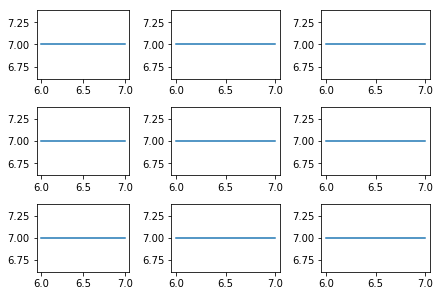

In [42]:
widths =  [6, 7, 7]
heights = [7, 7, 7]

gs_kw = dict(width_ratios=widths, height_ratios=heights)
fig6, f6_axes = plt.subplots(ncols=3, nrows=3, constrained_layout=True,gridspec_kw=gs_kw)
for r, row in enumerate(f6_axes):
    for c, ax in enumerate(row):
        label = 'Width: {}\nHeight: {}'.format(widths[c], heights[r])
        ax.plot(widths,heights)

# Robost linear regression

attack is: icmp scenario is: scen1 and alpha is[[0.02783055]]
attack is: icmp scenario is: scen2 and alpha is[[0.02754733]]
attack is: icmp scenario is: scen3 and alpha is[[0.03056611]]
attack is: icmp scenario is: scen4 and alpha is[[0.03583474]]
attack is: tcp scenario is: scen1 and alpha is[[0.03297764]]
attack is: tcp scenario is: scen1 and alpha is[[0.03565288]]
attack is: tcp scenario is: scen1 and alpha is[[0.03286915]]
attack is: tcp scenario is: scen2 and alpha is[[0.02913933]]
attack is: tcp scenario is: scen2 and alpha is[[0.03347868]]
attack is: tcp scenario is: scen2 and alpha is[[0.02813762]]
attack is: tcp scenario is: scen3 and alpha is[[0.02986634]]
attack is: tcp scenario is: scen3 and alpha is[[0.02716171]]
attack is: tcp scenario is: scen3 and alpha is[[0.02955315]]
attack is: tcp scenario is: scen4 and alpha is[[0.02516072]]
attack is: tcp scenario is: scen4 and alpha is[[0.0369277]]
attack is: tcp scenario is: scen4 and alpha is[[0.0098491]]
[Errno 2] File /home/y

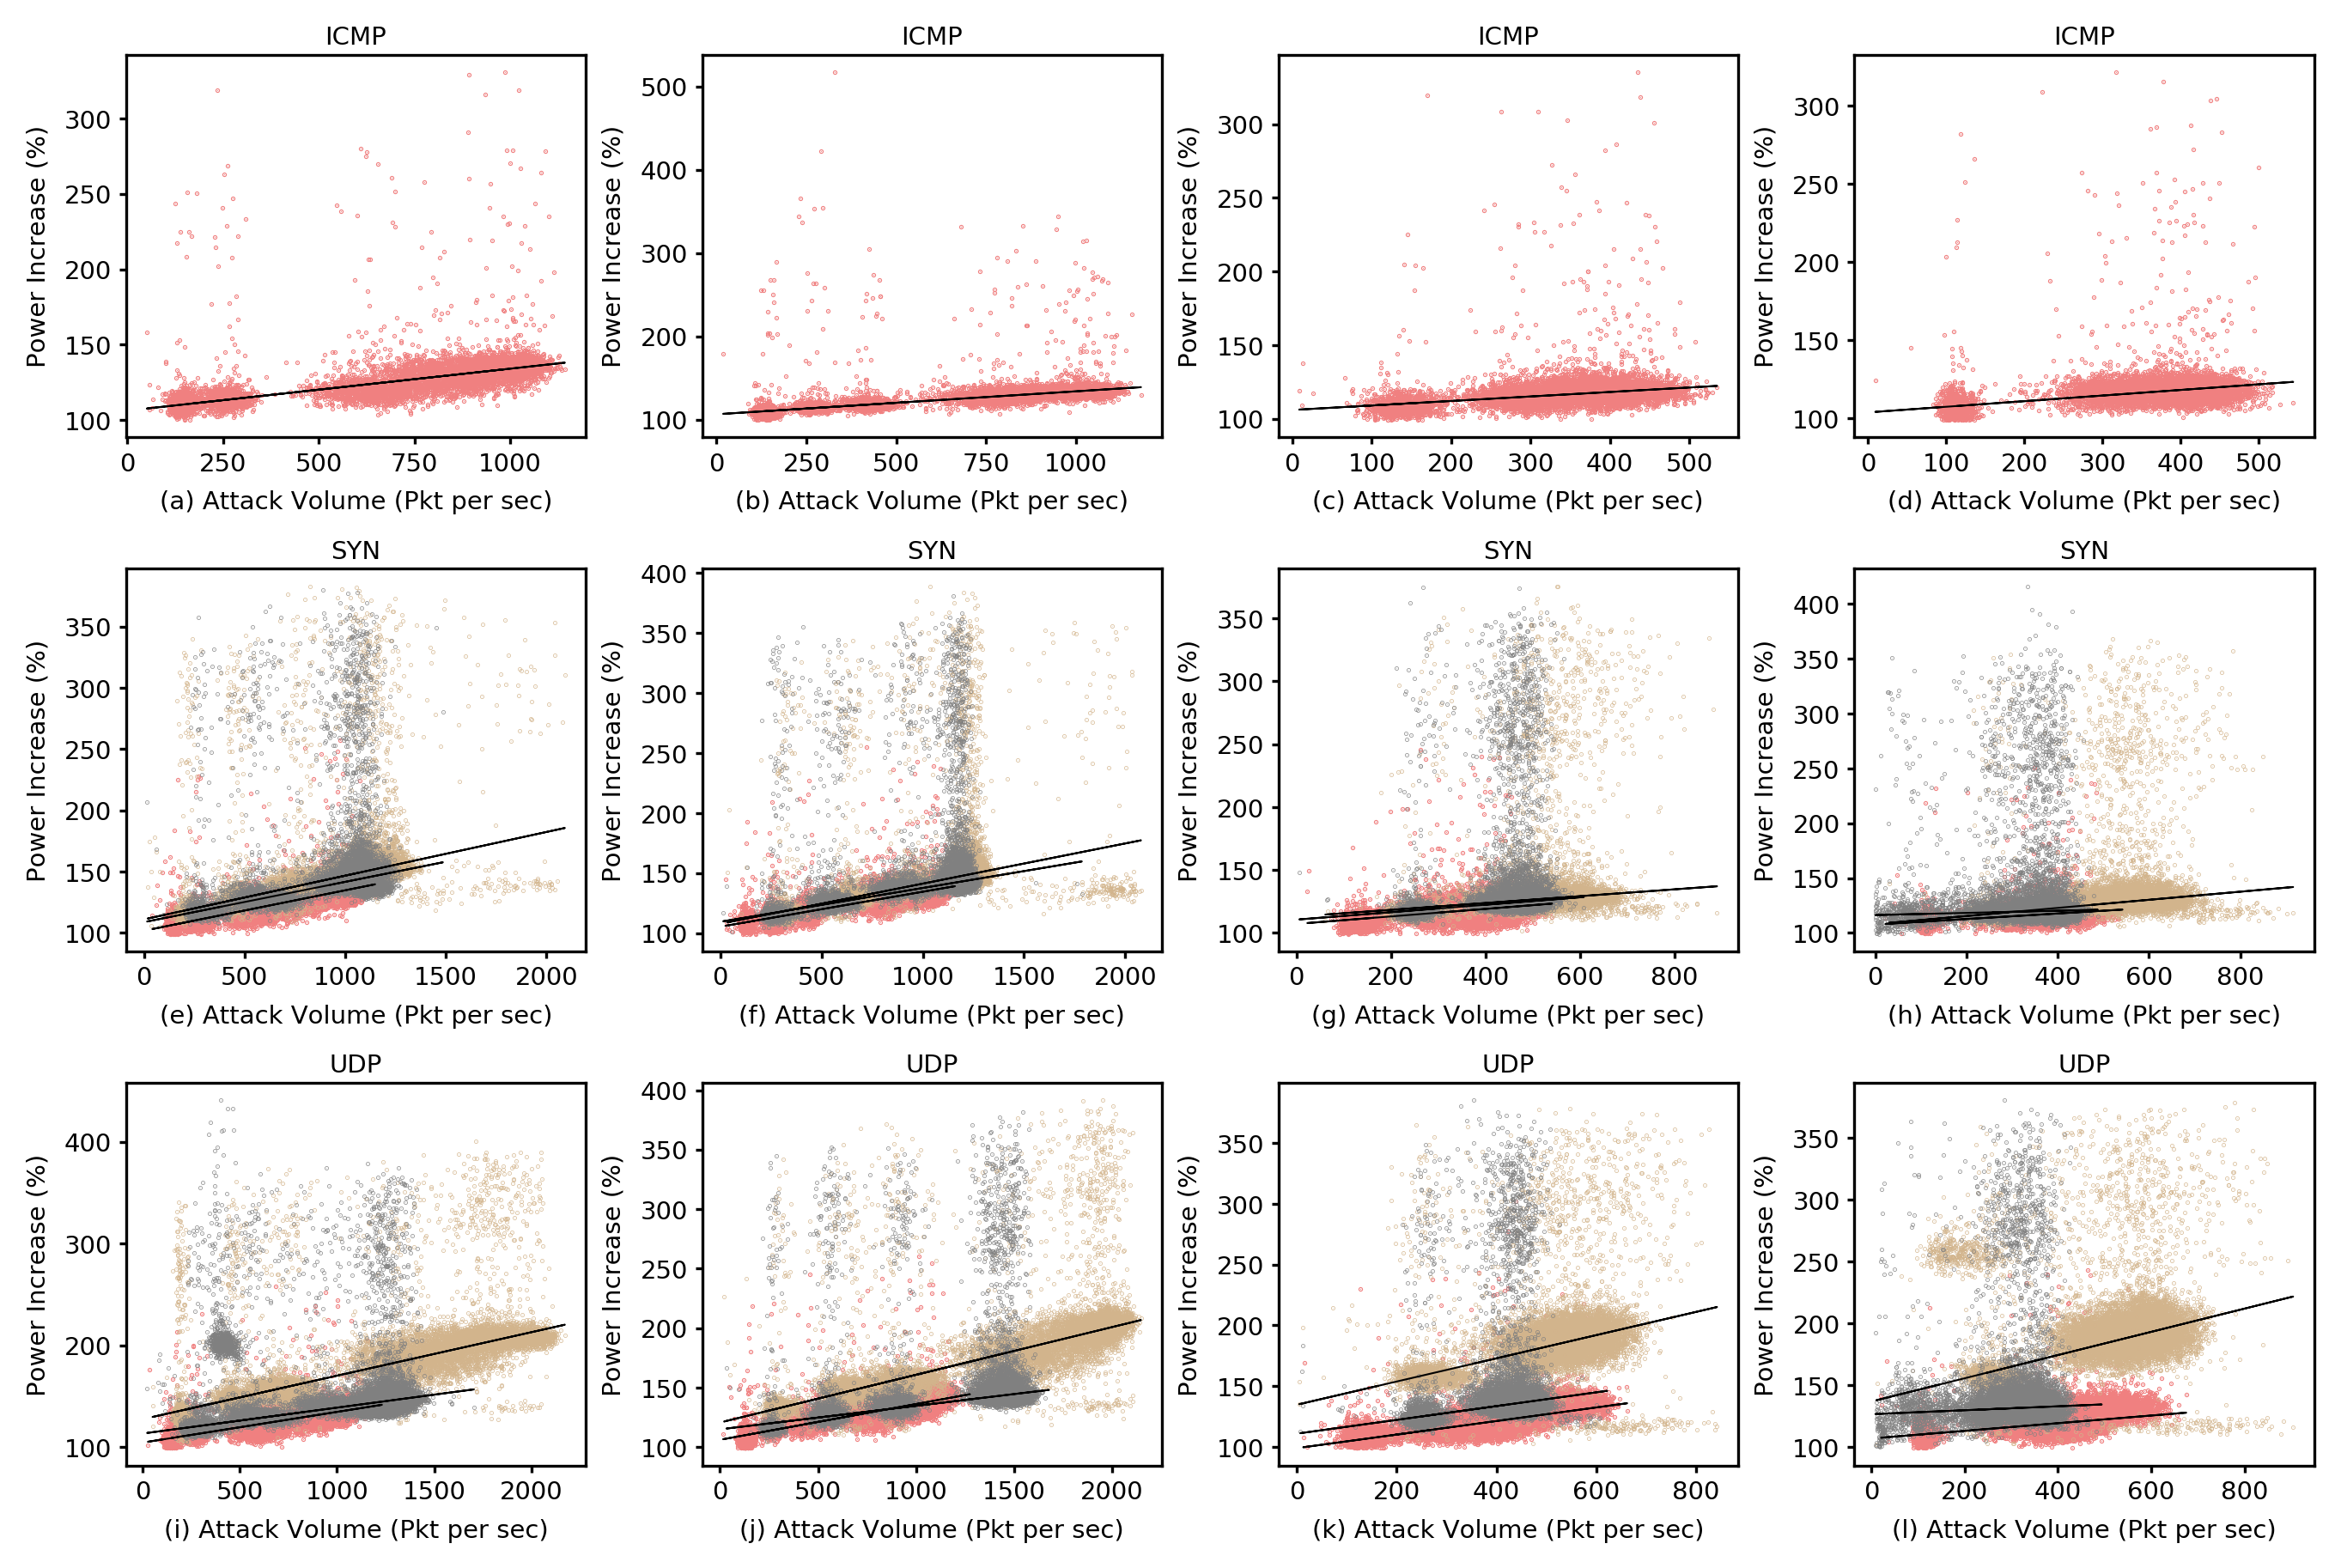

In [9]:
#%%writefile plot_graph.py
from variables import *
scen_line   = [mlines.Line2D([], [], linestyle='none',label='$P_L$,$R_7$')
 			  ,mlines.Line2D([], [], linestyle='none', label='$P_L$,$R_1$')
			  ,mlines.Line2D([], [],linestyle='none', label='$P_H$,$R_1$')
			  ,mlines.Line2D([], [],linestyle='none', label='$P_H$,$R_7$')]

label_type = ['$P_L$,$R_7$','$P_L$,$R_1$','$P_H$,$R_1$','$P_H$,$R_7$']

scen_line_tcp = [mlines.Line2D([], [],linestyle='none'),
                  mlines.Line2D([], [], linestyle='none',marker='.',color= 'grey'),
                  mlines.Line2D([], [],linestyle='none', marker='.',color= 'tan')]

scen_line_udp = [mlines.Line2D([], [],linestyle='none',label= label_type),
                  mlines.Line2D([], [], linestyle='none',marker='.',color= 'grey' ),
                  mlines.Line2D([], [],linestyle='none', marker='.',color= 'tan')]

# port_state = 'a_tcp_close_udp_close'
# port_state = 'a_tcp_filter_udp_filter'
# port_state = 'a_tcp_open_udp_open'

power_label      = 100
powerstep_size   = 20
graph_rows       = 3
graph_cols       = 4
fig_size         = (9,6)
pps_label1       = 2501     # for scen 1 and scen 2
pps_lebel2       = 1501     # for scen 1 and scen 2
pps_stepsize1    = 500      # for scen 3 and scen 4
pps_stepsize2    = 300      # for scen 3 and scen 4
graph_title      = ["ICMP","SYN","UDP"]
fig,axes   = plt.subplots(nrows=graph_rows, ncols=graph_cols, dpi=300, figsize=(9,6))
axes_list  = [item for sublist in axes for item in sublist] 
lm = linear_model.LinearRegression()
model_ransac = linear_model.RANSACRegressor(min_samples=20,max_trials=600000)

    
i=0                                           # for different line style (colour and style) in graph
j=0                                           #for legend
k=97                                          #for a,b.... title of graph
n=0
p=0                                           # for scenarios since number of readings are different
r=0                                           # for attack names




for attack_type in ['icmp','tcp','udp']:
    j=0
    i=0
    for scenario in scenarios:
        axs = axes_list.pop(0)
        x__=  []
        y__=  []
        x1__= []
        y1__= []
        x2__= []
        y2__= []
        port_state = 'a_tcp_filter_udp_filter'
        for attack_th in attack_ths:
            if port_state == 'a_tcp_filter_udp_filter':
                fileCount = a_tcp_filter_udp_filter_fileCount(scenario,attack_type,attack_th)
            else:
                fileCount = [0,1,2,3,4]
            for reading_numb in fileCount:
                try:
                    
                    port_state = 'a_tcp_filter_udp_filter'
                    csv_file_name1 = device+attack_type+str(attack_th)+'out'+str(reading_numb)
                    csv_file_loc1  = '/home/ydalal/media/bhagyashri/%s/%s/df_rate_power_500ms/%s/%s.csv'%(device,port_state,scenario,csv_file_name1)
                    df_out_merged  = pd.read_csv(csv_file_loc1,sep=',',names=['nanosecond','power_attack','power_perc_chng','time','attack_rate'], low_memory=False)
                    df_out_merged.drop(df_out_merged.index[0], inplace=True)
                    x__.extend(df_out_merged.attack_rate.values)
                    y__.extend(df_out_merged.power_perc_chng.values)
                    
                    if (attack_type=='tcp' or attack_type == 'udp'):
                        port_state     = "a_tcp_open_udp_open"
                        csv_file_loc2  = '/home/ydalal/media/bhagyashri/%s/%s/df_rate_power_500ms/%s/%s.csv'%(device,port_state,scenario,csv_file_name1)
                        df_out_merged1 = pd.read_csv(csv_file_loc2,sep=',',names=['nanosecond','power_attack','power_perc_chng','time','attack_rate'], low_memory=False)
                        df_out_merged1.drop(df_out_merged1.index[0], inplace=True)
                        x1__.extend(df_out_merged1.attack_rate.values)
                        y1__.extend(df_out_merged1.power_perc_chng.values)
                
                        
                        port_state = "a_tcp_close_udp_close"
                        csv_file_loc3    = '/home/ydalal/media/bhagyashri/%s/%s/df_rate_power_500ms/%s/%s.csv'%(device,port_state,scenario,csv_file_name1)
                        df_out_merged3 = pd.read_csv(csv_file_loc3,sep=',',names=['nanosecond','power_attack','power_perc_chng','time','attack_rate'], low_memory=False)
                        df_out_merged3.drop(df_out_merged3.index[0], inplace=True)
                        x2__.extend(df_out_merged3.attack_rate.values)
                        y2__.extend(df_out_merged3.power_perc_chng.values)
                        
                except Exception as e:
                    print(e)
                    continue
        
        x__=map(float, x__)
        y__=map(float, y__)  
        df = pd.DataFrame(zip(x__,y__),columns=['attack_rate','percntg_power_change'])
        df = df[df['percntg_power_change'] > 99]
        independent_variable_rate = df.attack_rate.values.reshape(-1,1)
        dependent_varaiable_power = df.percntg_power_change.values.reshape(-1,1)
        # plot scatter
        axs.scatter(df['attack_rate'],df['percntg_power_change'],s=.07, color='lightcoral')


        # fit robost linear regression
        model_ransac.fit(independent_variable_rate,dependent_varaiable_power)
        power_pred_robost = model_ransac.predict(independent_variable_rate)
        axs.plot(df['attack_rate'], power_pred_robost, color='k', linewidth=.5)
        print ("attack is: "+attack_type+" scenario is: "+scenario+" and alpha is"+str(model_ransac.estimator_.coef_))
        

        if (attack_type=='tcp' or attack_type == 'udp'):
            x1__=map(float, x1__)
            y1__=map(float, y1__)  
            df1 = pd.DataFrame(zip(x1__,y1__),columns=['attack_rate','percntg_power_change'])
            df1 = df1[df1['percntg_power_change'] > 99]
            independent_variable_rate1 = df1.attack_rate.values.reshape(-1,1)
            dependent_varaiable_power1 = df1.percntg_power_change.values.reshape(-1,1)
            # plot scatter
            axs.scatter(df1['attack_rate'],df1['percntg_power_change'],s=.1,marker= '.', color='tan')
            

    
            # fit robost linear regression
            model_ransac.fit(independent_variable_rate1,dependent_varaiable_power1)
            power_pred_robost = model_ransac.predict(independent_variable_rate1)
            axs.plot(df1['attack_rate'], power_pred_robost, color='k', linewidth=.5)
            print ("attack is: "+attack_type+" scenario is: "+scenario+" and alpha is"+str(model_ransac.estimator_.coef_))



            x2__=map(float, x2__)
            y2__=map(float, y2__)  
            df2 = pd.DataFrame(zip(x2__,y2__),columns=['attack_rate','percntg_power_change'])
            df2 = df2[df2['percntg_power_change'] > 99]
            independent_variable_rate2 = df2.attack_rate.values.reshape(-1,1)
            dependent_varaiable_power2 = df2.percntg_power_change.values.reshape(-1,1)
            
            # plot scatter
            axs.scatter(df2['attack_rate'],df2['percntg_power_change'],s=.1,marker= '.', color='grey')


            
            # fit robost linear regression
            model_ransac.fit(independent_variable_rate2,dependent_varaiable_power2)
            power_pred_robost = model_ransac.predict(independent_variable_rate2)
            axs.plot(df2['attack_rate'], power_pred_robost, color='k', linewidth=.5)
            print ("attack is: "+attack_type+" scenario is: "+scenario+" and alpha is"+str(model_ransac.estimator_.coef_))

            #print ("attack is: "+attack_type+" scenario is: "+scenario+" and alpha is"+str(lm.coef_))

        
        axs.set_xlabel ("("+ chr(k) + ")" + " Attack Volume"+" ("+"Pkt per sec"+")", fontsize=7)           
        axs.set_ylabel("Power Increase (%)", fontsize=7)
        axs.set_title(graph_title[n], fontsize=7,pad=3)
        axs.tick_params(right=False, top=False, labelsize=7,colors="k", length=2,pad=2)  #primary y and x
#         axs.set_yticks(np.arange(0,401, step = 100)) # primary y axis (bandwidth
#         axs.set_xticks(np.arange(0,1301, step = 400)) # 500ms
        #axs.set_xticks(np.arange(0,2501, step = 600)) # 1sec

#         if (attack_type=='tcp'):
#             axs.legend(scen_line_tcp,[label_type[i],'filtered port','open port'],ncol=1 , loc= 'upper right',borderpad= .5,fontsize = '7', frameon=False,numpoints=1)
        
#         elif (attack_type == 'udp'):
#             axs.legend(scen_line_udp,[label_type[i],'filtered port','open port'],ncol=1 , loc= 'upper right',borderpad= .5,fontsize = '7', frameon=False,numpoints=1)

#         else:
#             axs.legend(handles=[scen_line[i]],ncol=1, loc= 'upper right',borderpad= .5,fontsize = '7', frameon=False,numpoints=1)

#         if ((attack_type == 'icmp') and (scenario == 'scen1' or scenario == 'scen2')):
#             axs.set_xticks(np.arange(0,2401, step = 600))
        
#         elif ((attack_type == 'icmp') and (scenario == 'scen3' or scenario == 'scen4')):
#             axs.set_xticks(np.arange(0,1201, step = 400))
                        
#         elif ((attack_type == 'tcp') and (scenario == 'scen1' or scenario == 'scen2')):
#             axs.set_xticks(np.arange(0,4401, step = 1100))
        
#         elif ((attack_type == 'udp') and (scenario == 'scen1' or scenario == 'scen2')):
#             axs.set_xticks(np.arange(0,4501, step = 900))
        
#         elif ((attack_type == 'tcp' or attack_type == 'udp') and (scenario == 'scen3' or scenario == 'scen4')):
#             axs.set_xticks(np.arange(0,2001, step = 500))
        
        i=i+1
        k=k+1
    n=n+1
plt.tight_layout(pad=0.4, w_pad=0.4, h_pad=.7)
plt.savefig('echo500ms4.jpg',bbox_inches="tight") #bbox_inches='tight' : remove white spaces          
# echo_byte = BytesIO()
# plt.savefig(echo_byte,fromat = 'eps',bbox_inches="tight") #bbox_inches='tight' : remove white spaces          
# echo_image = Image.open(echo_byte)
# echo_image.save('echo500ms2.tiff')
# echo_byte.close()
# df_out_sec_merged

# robost 1

attack is: icmp scenario is: scen1 and alpha is[[0.02801258]]
attack is: icmp scenario is: scen2 and alpha is[[0.02746084]]
attack is: icmp scenario is: scen3 and alpha is[[0.03057355]]
attack is: icmp scenario is: scen4 and alpha is[[0.03583096]]
attack is: tcp scenario is: scen1 and alpha is[[0.03332721]]
attack is: tcp scenario is: scen1 and alpha is[[0.03559541]]
attack is: tcp scenario is: scen1 and alpha is[[0.03279561]]
attack is: tcp scenario is: scen2 and alpha is[[0.0291203]]
attack is: tcp scenario is: scen2 and alpha is[[0.03317745]]
attack is: tcp scenario is: scen2 and alpha is[[0.0280601]]
attack is: tcp scenario is: scen3 and alpha is[[0.02989235]]
attack is: tcp scenario is: scen3 and alpha is[[0.0273181]]
attack is: tcp scenario is: scen3 and alpha is[[0.02972163]]
attack is: tcp scenario is: scen4 and alpha is[[0.02614628]]
attack is: tcp scenario is: scen4 and alpha is[[0.03667269]]
attack is: tcp scenario is: scen4 and alpha is[[0.00986881]]
[Errno 2] File /home/yd

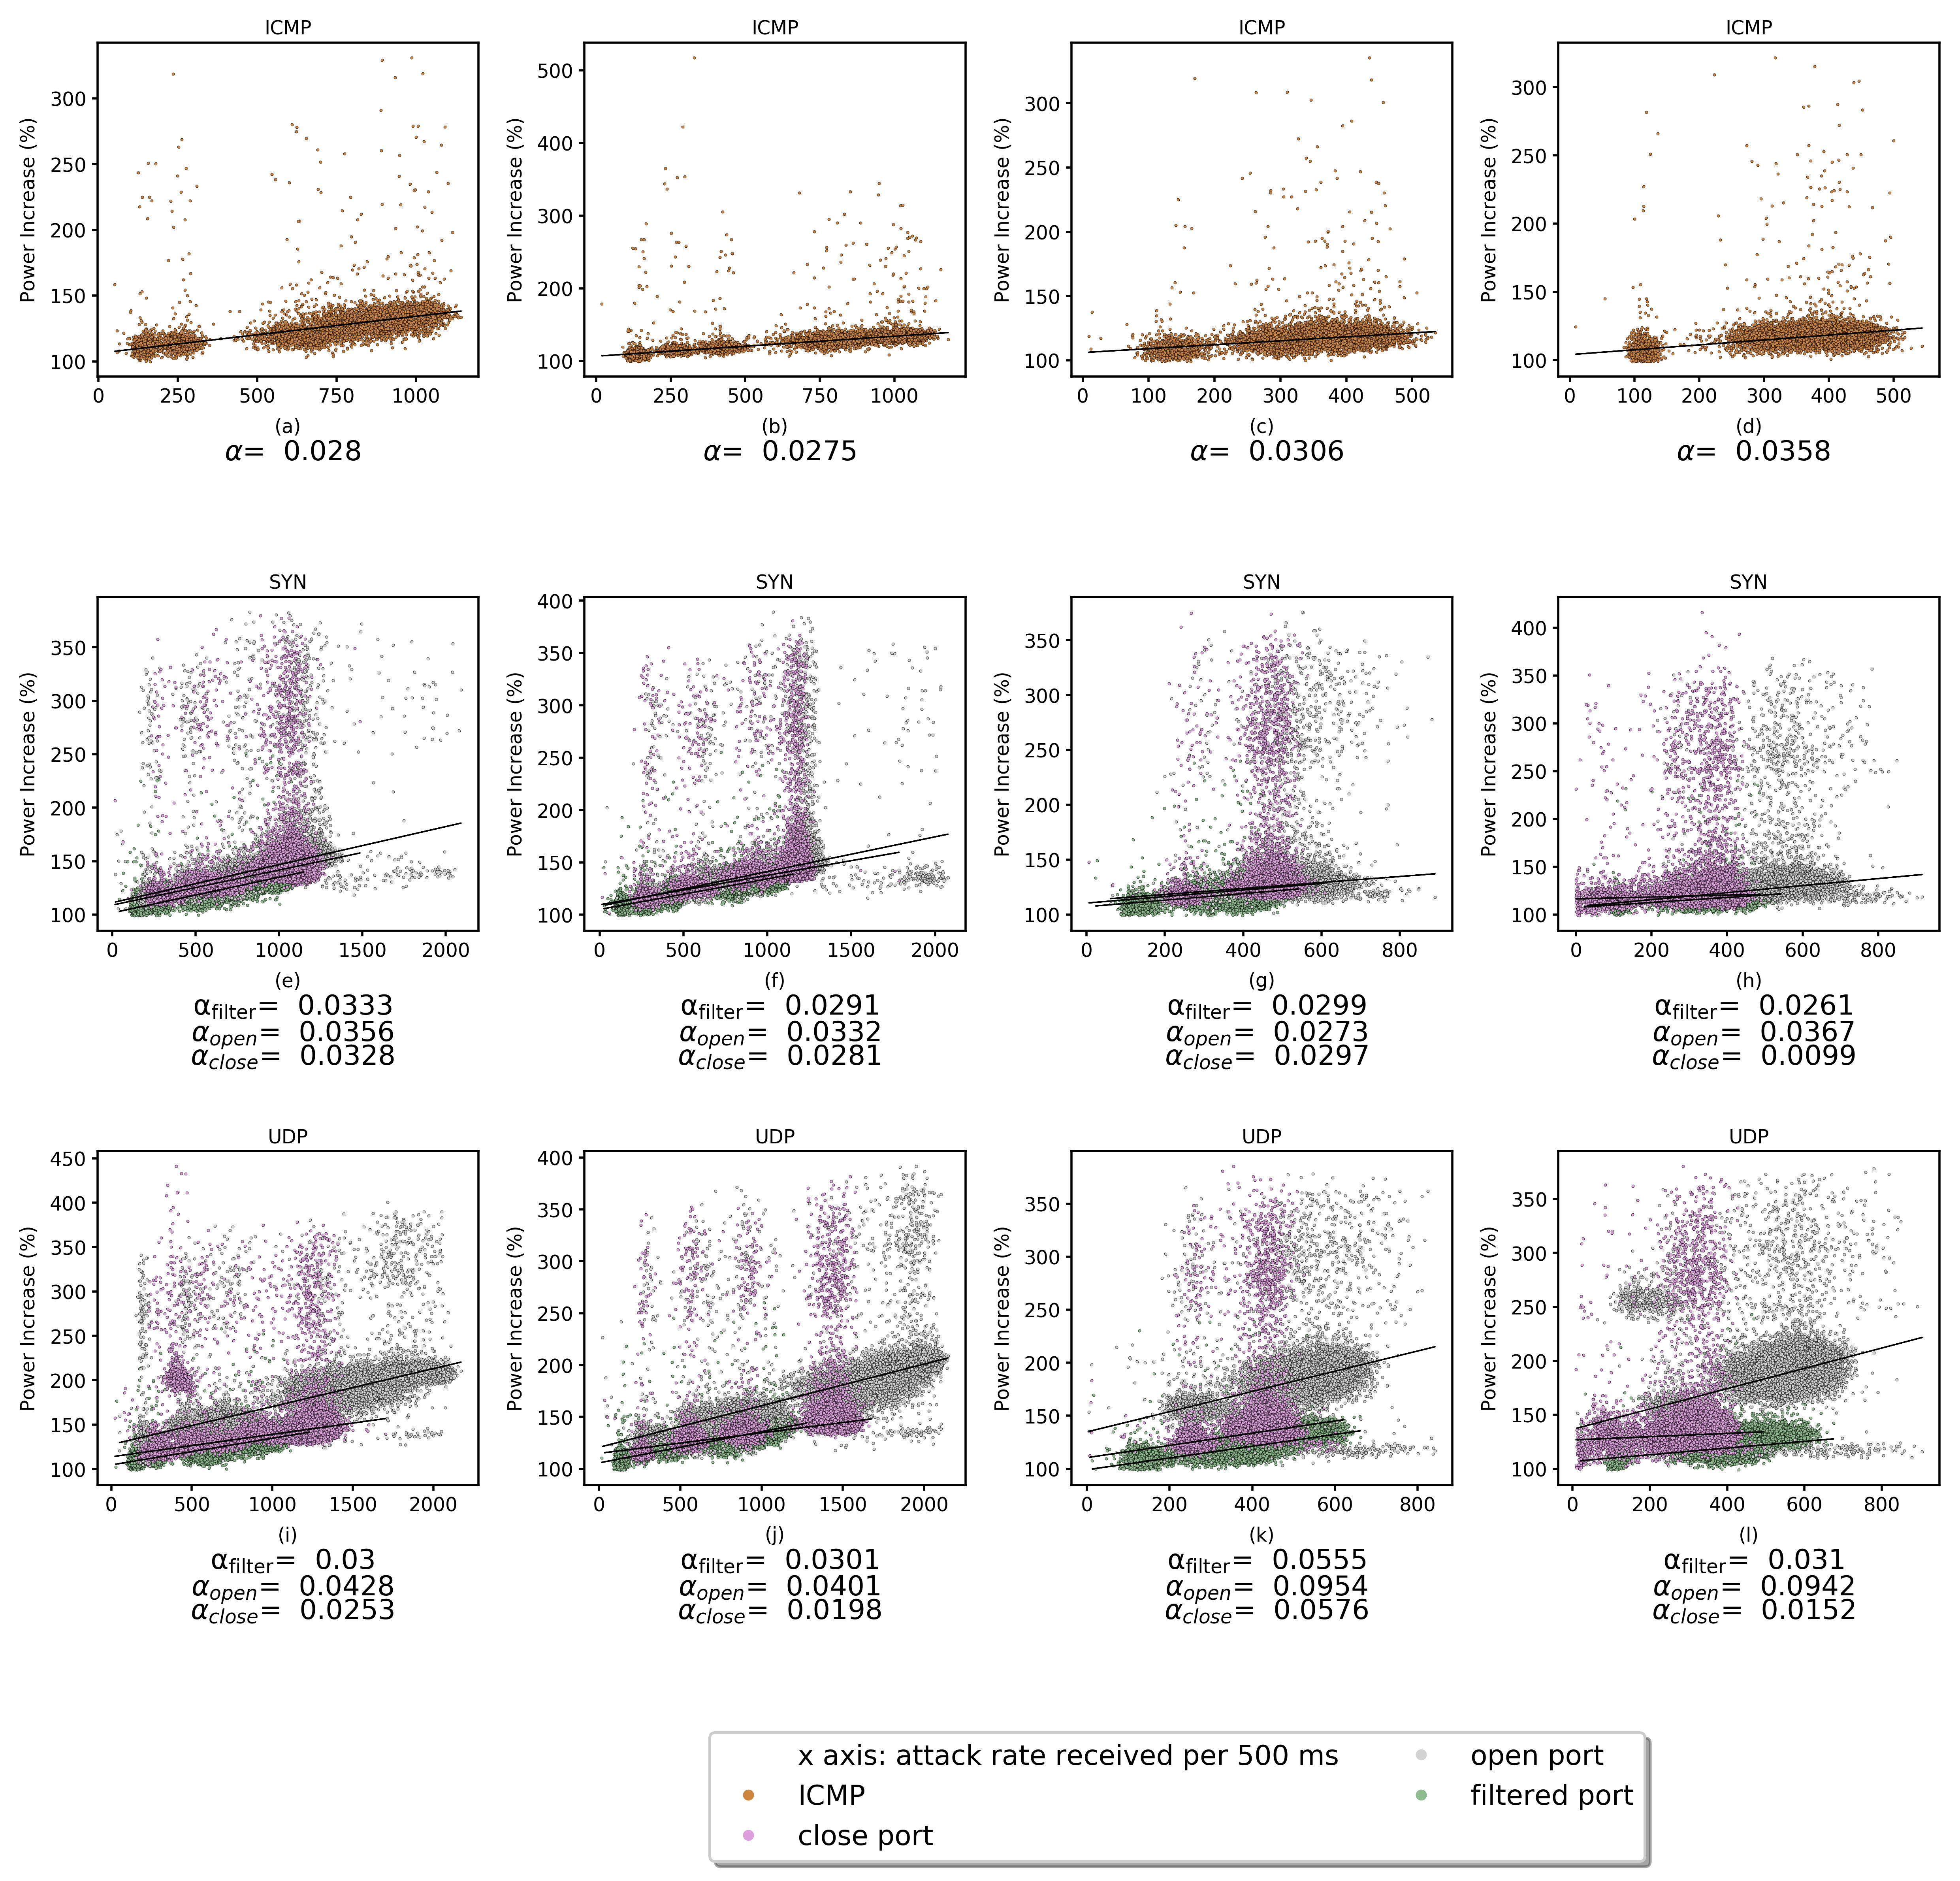

In [16]:
#%%writefile plot_graph.py
from variables import *
scen_line   = [mlines.Line2D([], [], linestyle='none',label='$P_L$,$R_7$')
 			  ,mlines.Line2D([], [], linestyle='none', label='$P_L$,$R_1$')
			  ,mlines.Line2D([], [],linestyle='none', label='$P_H$,$R_1$')
			  ,mlines.Line2D([], [],linestyle='none', label='$P_H$,$R_7$')]

label_type = ['$P_L$,$R_7$','$P_L$,$R_1$','$P_H$,$R_1$','$P_H$,$R_7$']


legend_elements = [mlines.Line2D([], [], linestyle='none',label='x axis: attack rate received per 500 ms'),
                   mlines.Line2D([], [], linestyle='none',marker='.',color= 'peru',label="ICMP"),
                   mlines.Line2D([], [], linestyle='none',marker='.',color= 'plum',label="close port"),
                   mlines.Line2D([], [], linestyle='none',marker='.',color= 'lightgrey',label="open port"),
                   mlines.Line2D([], [], linestyle='none',marker='.',color= 'darkseagreen',label="filtered port")]

power_label      = 100
powerstep_size   = 20
graph_rows       = 3
graph_cols       = 4
# fig_size         = (12,9)
pps_label1       = 2501     # for scen 1 and scen 2
pps_lebel2       = 1501     # for scen 1 and scen 2
pps_stepsize1    = 500      # for scen 3 and scen 4
pps_stepsize2    = 300      # for scen 3 and scen 4
graph_title      = ["ICMP","SYN","UDP"]
marker_array     = ["o", "o","o"]
marker_id        = 0
fig,axes   = plt.subplots(nrows=graph_rows, ncols=graph_cols, dpi=500, figsize=(10,8))
axes_list  = [item for sublist in axes for item in sublist] 
lm = linear_model.LinearRegression()
model_ransac = linear_model.RANSACRegressor(min_samples=20,max_trials=600000)# 600000

alpha_array = []
alpha_id    = 0
i=0                                           # for different line style (colour and style) in graph
j=0                                           #for legend
k=97                                          #for a,b.... title of graph
n=0
p=0                                           # for scenarios since number of readings are different
r=0                                           # for attack names




for attack_type in ['icmp','tcp','udp']:
    j=0
    i=0
    for scenario in scenarios:
        axs = axes_list.pop(0)
        x__=  []
        y__=  []
        x1__= []
        y1__= []
        x2__= []
        y2__= []
        port_state = 'a_tcp_filter_udp_filter'
        for attack_th in attack_ths:
            if port_state == 'a_tcp_filter_udp_filter':
                fileCount = a_tcp_filter_udp_filter_fileCount(scenario,attack_type,attack_th)
            else:
                fileCount = [0,1,2,3,4]
            for reading_numb in fileCount:
                try:
                    
                    port_state = 'a_tcp_filter_udp_filter'
                    csv_file_name1 = device+attack_type+str(attack_th)+'out'+str(reading_numb)
                    csv_file_loc1  = '/home/ydalal/media/bhagyashri/%s/%s/df_rate_power_500ms/%s/%s.csv'%(device,port_state,scenario,csv_file_name1)
                    df_out_merged  = pd.read_csv(csv_file_loc1,sep=',',names=['nanosecond','power_attack','power_perc_chng','time','attack_rate'], low_memory=False)
                    df_out_merged.drop(df_out_merged.index[0], inplace=True)
                    x__.extend(df_out_merged.attack_rate.values)
                    y__.extend(df_out_merged.power_perc_chng.values)
                    
                    if (attack_type=='tcp' or attack_type == 'udp'):
                        port_state     = "a_tcp_open_udp_open"
                        csv_file_loc2  = '/home/ydalal/media/bhagyashri/%s/%s/df_rate_power_500ms/%s/%s.csv'%(device,port_state,scenario,csv_file_name1)
                        df_out_merged1 = pd.read_csv(csv_file_loc2,sep=',',names=['nanosecond','power_attack','power_perc_chng','time','attack_rate'], low_memory=False)
                        df_out_merged1.drop(df_out_merged1.index[0], inplace=True)
                        x1__.extend(df_out_merged1.attack_rate.values)
                        y1__.extend(df_out_merged1.power_perc_chng.values)
                
                        
                        port_state = "a_tcp_close_udp_close"
                        csv_file_loc3    = '/home/ydalal/media/bhagyashri/%s/%s/df_rate_power_500ms/%s/%s.csv'%(device,port_state,scenario,csv_file_name1)
                        df_out_merged3 = pd.read_csv(csv_file_loc3,sep=',',names=['nanosecond','power_attack','power_perc_chng','time','attack_rate'], low_memory=False)
                        df_out_merged3.drop(df_out_merged3.index[0], inplace=True)
                        x2__.extend(df_out_merged3.attack_rate.values)
                        y2__.extend(df_out_merged3.power_perc_chng.values)
                        
                except Exception as e:
                    print(e)
                    continue
        
        
        
        if attack_type == "icmp":
            x__=map(float, x__)
            y__=map(float, y__)  
            df = pd.DataFrame(zip(x__,y__),columns=['attack_rate','percntg_power_change'])
            df = df[df['percntg_power_change'] > 99]
            independent_variable_rate = df.attack_rate.values.reshape(-1,1)
            dependent_varaiable_power = df.percntg_power_change.values.reshape(-1,1)
            axs.scatter(df['attack_rate'],df['percntg_power_change'],s=1,marker= marker_array[marker_id],facecolors='peru', edgecolors='k',linewidth = 0.1,alpha=1)
            
            # fit robost linear regression
            model_ransac.fit(independent_variable_rate,dependent_varaiable_power)
            power_pred_robost = model_ransac.predict(independent_variable_rate)
            axs.plot(df['attack_rate'], power_pred_robost, color='k', linewidth=.5)
            print ("attack is: "+attack_type+" scenario is: "+scenario+" and alpha is"+str(model_ransac.estimator_.coef_))

            a__         = model_ransac.estimator_.coef_[0]
            b__         = a__[0]
            alpha_array.append(round (b__,4)) 
            axs.set_xlabel ("("+ chr(k) + ")", fontsize=7)           
            axs.text(0.5,-0.25, r' $\alpha$= ' + " " +str(alpha_array[alpha_id]), size=10, ha="center", transform=axs.transAxes)
            alpha_id = alpha_id + 1
        else:
            
            x__=map(float, x__)
            y__=map(float, y__)  
            df = pd.DataFrame(zip(x__,y__),columns=['attack_rate','percntg_power_change'])
            df = df[df['percntg_power_change'] > 99]
            independent_variable_rate = df.attack_rate.values.reshape(-1,1)
            dependent_varaiable_power = df.percntg_power_change.values.reshape(-1,1)
            axs.scatter(df['attack_rate'],df['percntg_power_change'],s=1,marker= marker_array[marker_id],facecolors='darkseagreen', edgecolors='k',linewidth = 0.1,alpha=1)
            
            # fit robost linear regression
            model_ransac.fit(independent_variable_rate,dependent_varaiable_power)
            power_pred_robost = model_ransac.predict(independent_variable_rate)
            axs.plot(df['attack_rate'], power_pred_robost, color='k', linewidth=.5)
            print ("attack is: "+attack_type+" scenario is: "+scenario+" and alpha is"+str(model_ransac.estimator_.coef_))
            a__         = model_ransac.estimator_.coef_[0]
            b__         = a__[0]
            alpha_array.append(round (b__,4)) 
            axs.set_xlabel ("("+ chr(k) + ")", fontsize=7)           
            axs.text(0.5,-0.25, r' $\mathrm{\alpha_{filter}}$= ' + " " +str(alpha_array[alpha_id]), size=10, ha="center", transform=axs.transAxes)
            alpha_id = alpha_id + 1
        
        if (attack_type=='tcp' or attack_type == 'udp'):
            x1__=map(float, x1__)
            y1__=map(float, y1__)  
            df1 = pd.DataFrame(zip(x1__,y1__),columns=['attack_rate','percntg_power_change'])
            df1 = df1[df1['percntg_power_change'] > 99]
            independent_variable_rate1 = df1.attack_rate.values.reshape(-1,1)
            dependent_varaiable_power1 = df1.percntg_power_change.values.reshape(-1,1)
            axs.scatter(df1['attack_rate'],df1['percntg_power_change'],s=1,marker= marker_array[marker_id],facecolors='lightgrey', edgecolors='k',linewidth = 0.1,alpha=1)
            
            
            # fit robost linear regression
            model_ransac.fit(independent_variable_rate1,dependent_varaiable_power1)
            power_pred_robost = model_ransac.predict(independent_variable_rate1)
            axs.plot(df1['attack_rate'], power_pred_robost, color='k', linewidth=.5)
            print ("attack is: "+attack_type+" scenario is: "+scenario+" and alpha is"+str(model_ransac.estimator_.coef_))
            a__         = model_ransac.estimator_.coef_[0]
            b__         = a__[0]
            alpha_array.append(round (b__,4)) 
            axs.text(0.5,-0.33, r' $\alpha_{open}$= ' + " " +str(alpha_array[alpha_id]), size=10, ha="center", transform=axs.transAxes)
            alpha_id = alpha_id + 1

            
            x2__=map(float, x2__)
            y2__=map(float, y2__)  
            df2 = pd.DataFrame(zip(x2__,y2__),columns=['attack_rate','percntg_power_change'])
            df2 = df2[df2['percntg_power_change'] > 99]
            independent_variable_rate2 = df2.attack_rate.values.reshape(-1,1)
            dependent_varaiable_power2 = df2.percntg_power_change.values.reshape(-1,1)
            axs.scatter(df2['attack_rate'],df2['percntg_power_change'],s=1,marker= marker_array[marker_id],facecolors='plum', edgecolors='k',linewidth = 0.1,alpha=1)
            
            # fit robost linear regression
            model_ransac.fit(independent_variable_rate2,dependent_varaiable_power2)
            power_pred_robost = model_ransac.predict(independent_variable_rate2)
            axs.plot(df2['attack_rate'], power_pred_robost, color='k', linewidth=.5)
            print ("attack is: "+attack_type+" scenario is: "+scenario+" and alpha is"+str(model_ransac.estimator_.coef_))
            a__         = model_ransac.estimator_.coef_[0]
            b__         = a__[0]
            alpha_array.append(round (b__,4)) 
            axs.text(0.5,-0.4, r' $\alpha_{close}$= ' + " " +str(alpha_array[alpha_id]), size=10, ha="center", transform=axs.transAxes)
            alpha_id = alpha_id + 1

        axs.set_ylabel("Power Increase (%)", fontsize=7)
        axs.set_title(graph_title[n], fontsize=7,pad=3)
        axs.tick_params(right=False, top=False, labelsize=7,colors="k", length=2,pad=2)  #primary y and x
#         axs.set_yticks(np.arange(0,301, step = 100)) # primary y axis (bandwidth
#         axs.set_xticks(np.arange(0,1301, step = 400)) # 500ms
        #axs.set_xticks(np.arange(0,2501, step = 600)) # 1sec

#         if (attack_type=='tcp'):
#             axs.legend(scen_line_tcp,[label_type[i],'filtered port','open port'],ncol=1 , loc= 'upper right',borderpad= .5,fontsize = '7', frameon=False,numpoints=1)
        
#         elif (attack_type == 'udp'):
#             axs.legend(scen_line_udp,[label_type[i],'filtered port','open port'],ncol=1 , loc= 'upper right',borderpad= .5,fontsize = '7', frameon=False,numpoints=1)

#         else:
#             axs.legend(handles=[scen_line[i]],ncol=1, loc= 'upper right',borderpad= .5,fontsize = '7', frameon=False,numpoints=1)

#         if ((attack_type == 'icmp') and (scenario == 'scen1' or scenario == 'scen2')):
#             axs.set_xticks(np.arange(0,2401, step = 600))
        
#         elif ((attack_type == 'icmp') and (scenario == 'scen3' or scenario == 'scen4')):
#             axs.set_xticks(np.arange(0,1201, step = 400))
                        
#         elif ((attack_type == 'tcp') and (scenario == 'scen1' or scenario == 'scen2')):
#             axs.set_xticks(np.arange(0,4401, step = 1100))
        
#         elif ((attack_type == 'udp') and (scenario == 'scen1' or scenario == 'scen2')):
#             axs.set_xticks(np.arange(0,4501, step = 900))
        
#         elif ((attack_type == 'tcp' or attack_type == 'udp') and (scenario == 'scen3' or scenario == 'scen4')):
#             axs.set_xticks(np.arange(0,2001, step = 500))
        
        i=i+1
        k=k+1
    n=n+1
    marker_id = marker_id +1 

plt.tight_layout(pad=1, w_pad=1, h_pad=5)
# plt.savefig('echo500ms4.jpg',bbox_inches="tight") #bbox_inches='tight' : remove white spaces          
# echo_byte = BytesIO()
axs.legend(handles=legend_elements,loc='upper center', bbox_to_anchor=(-1, -.7), shadow=True, ncol=2)

plt.savefig("echo.eps",bbox_inches="tight") #bbox_inches='tight' : remove white spaces   

# echo_image = Image.open(echo_byte)
# echo_image.save('echo500ms2.tiff')
# echo_byte.close()
# df_out_sec_merged

# Plot graph using sklearn

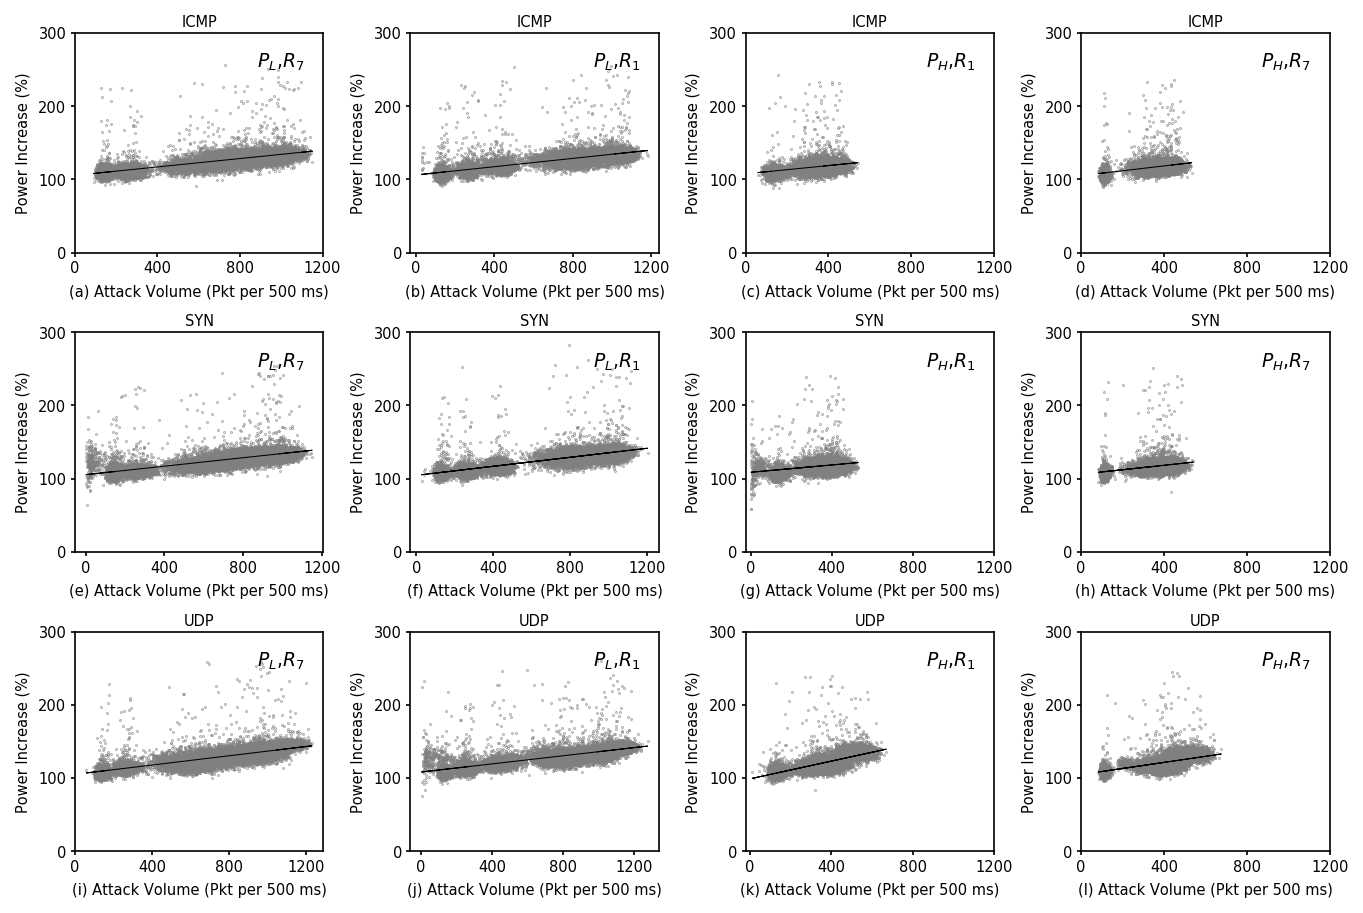

In [30]:
#%%writefile plot_graph.py
from variables import *
scen_line   = [mlines.Line2D([], [], linestyle='none',label='$P_L$,$R_7$')
 			  ,mlines.Line2D([], [], linestyle='none', label='$P_L$,$R_1$')
			  ,mlines.Line2D([], [],linestyle='none', label='$P_H$,$R_1$')
			  ,mlines.Line2D([], [],linestyle='none', label='$P_H$,$R_7$')]
power_label      = 100
powerstep_size   = 20
graph_rows       = 3
graph_cols       = 4
fig_size         = (9,6)
pps_label1       = 2501     # for scen 1 and scen 2
pps_lebel2       = 1501     # for scen 1 and scen 2
pps_stepsize1    = 500      # for scen 3 and scen 4
pps_stepsize2    = 300      # for scen 3 and scen 4
graph_title      = ["ICMP","SYN","UDP"]
fig,axes   = plt.subplots(nrows=graph_rows, ncols=graph_cols, dpi=150, figsize=(9,6))
axes_list  = [item for sublist in axes for item in sublist] 
lm = linear_model.LinearRegression()

i=0                                           # for different line style (colour and style) in graph
j=0                                           #for legend
k=97                                          #for a,b.... title of graph
n=0
p=0                                           # for scenarios since number of readings are different
r=0                                           # for attack names

for attack_type in ['icmp','tcp','udp']:
    j=0
    i=0
    for scenario in scenarios:
        axs = axes_list.pop(0)
        if scenario == 'scen1' or scenario == 'scen2':
            fileCount = 9
        else:
            fileCount = 5
        x__= []
        y__= []

        for attack_th in attack_ths:
            row_index=0
            for reading_numb in range (0,fileCount):
                try:
                    csv_file_name1    = device+attack_type+str(attack_th)+'out'+str(reading_numb)
                    csv_file_loc1     = '/home/btushir/Desktop/smarthome_ddos/%s/%s/df_rate_power_500ms/%s/%s.csv'%(device,port_state,scenario,csv_file_name1)
                    #csv_file_loc1     = '/home/btushir/Desktop/smarthome_ddos/%s/df_rate_power/%s/%s.csv'%(device,scenario,csv_file_name1)

                    df_out_sec_merged = pd.read_csv(csv_file_loc1,sep=',',names=['nanosecond','power_attack','power_perc_chng','time','attack_rate'], low_memory=False)
                    df_out_sec_merged.drop(df_out_sec_merged.index[0], inplace=True)
                    
                    df_out_sec_merged.drop(df_out_sec_merged.head(20).index, inplace=True)


                    x__.extend(df_out_sec_merged.attack_rate.values)
                    y__.extend(df_out_sec_merged.power_perc_chng.values)
                    
                except Exception as e:
                    print(e)
                    continue

        x__=map(float, x__)
        y__=map(float, y__)  

        df = pd.DataFrame(zip(x__,y__),columns=['attack_rate','percntg_power_change'])
#         print (df.shape[0])
        independent_variable_rate = df.attack_rate.values.reshape(-1,1)
        dependent_varaiable_power = df.percntg_power_change.values.reshape(-1,1)
        lm.fit(independent_variable_rate,dependent_varaiable_power)
        #print ("attack is: "+attack_type+" scenario is: "+scenario+" and alpha is"+str(lm.coef_))
        #print ("attack is: "+attack_type+" and intercept is "+str(lm.intercept_))

        power_pred = lm.predict(independent_variable_rate)
        #print("error is:",math.sqrt(metrics.mean_squared_error(dependent_varaiable_power, power_pred)))
        axs.scatter(df['attack_rate'],df['percntg_power_change'],s=.07, color='grey')
        axs.plot(df['attack_rate'], power_pred, color='black', linewidth=.5)

        axs.set_xlabel ("("+ chr(k) + ")" + " Attack Volume"+" ("+"Pkt per 500 ms"+")", fontsize=7)           
        axs.set_ylabel("Power Increase (%)", fontsize=7)
        axs.set_title(graph_title[n], fontsize=7,pad=3)
        axs.tick_params(right=False, top=False, labelsize=7,colors="k", length=2,pad=2)  #primary y and x
        axs.set_yticks(np.arange(0,301, step = 100)) # primary y axis (bandwidth
        axs.set_xticks(np.arange(0,1301, step = 400)) # 500ms
        #axs.set_xticks(np.arange(0,2501, step = 600)) # 1sec

        #axs.legend(handles=[scen_line[0]],bbox_to_anchor=(x_loc, y_loc),ncol=1, borderpad= .5,fontsize = '5', frameon=False,numpoints=1)    
        axs.legend(handles=[scen_line[i]],ncol=1, loc= 'upper right',borderpad= .5,fontsize = '9', frameon=False,numpoints=1)
        
        i=i+1
        k=k+1
    n=n+1
plt.tight_layout(pad=0.4, w_pad=0.4, h_pad=.7)
#plt.savefig('1sec.eps',bbox_inches="tight") #bbox_inches='tight' : remove white spaces          
echo_byte = BytesIO()
plt.savefig(echo_byte,fromat = 'eps',bbox_inches="tight") #bbox_inches='tight' : remove white spaces          
echo_image = Image.open(echo_byte)
echo_image.save('echo500ms1.tiff')
echo_byte.close()

# Plot graphs using sns library

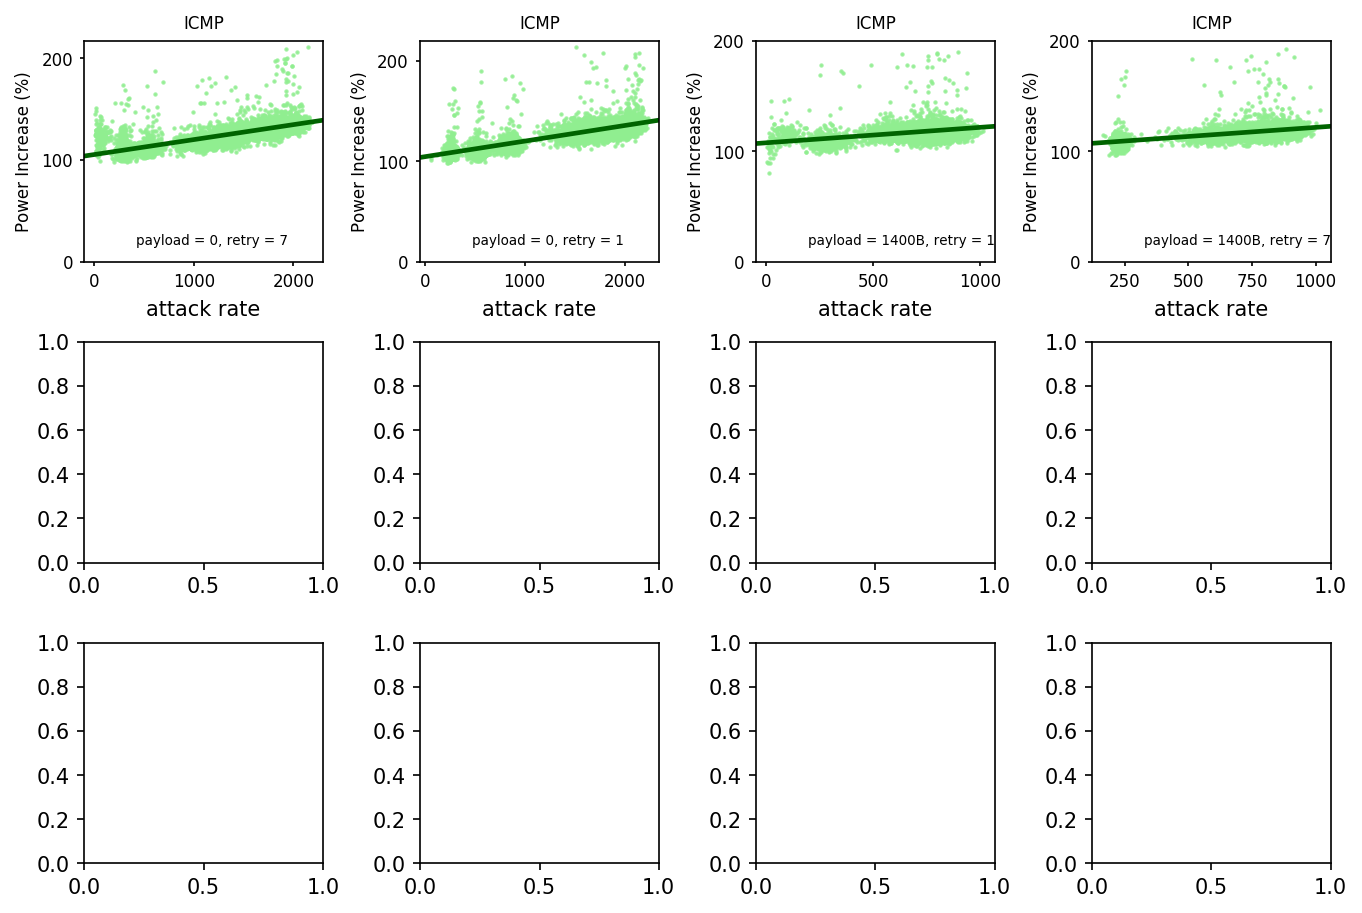

In [19]:
#%%writefile plot_graph.py
from variables import *

power_label      = 100
powerstep_size   = 20
graph_rows       = 3
graph_cols       = 4
fig_size         = (9,6)
pps_label1       = 2501     # for scen 1 and scen 2
pps_lebel2       = 1501     # for scen 1 and scen 2
pps_stepsize1    = 500      # for scen 3 and scen 4
pps_stepsize2    = 300      # for scen 3 and scen 4
graph_title      = ["ICMP","SYN","UDP"]
fig,axes   = plt.subplots(nrows=graph_rows, ncols=graph_cols, dpi=150, figsize=fig_size)
axes_list  = [item for sublist in axes for item in sublist] 

i=0                                           # for different line style (colour and style) in graph
j=0                                           #for legend
k=97                                          #for a,b.... title of graph
n=0
p=0                                           # for scenarios since number of readings are different
r=0                                           # for attack names

for attack_type in ['tcp']:
    j=0
    i=0
    for scenario in scenarios:
        axs = axes_list.pop(0)
        if scenario == 'scen1' or scenario == 'scen2':
            fileCount = 9
        else:
            fileCount = 5
        x__= []
        y__= []

        for attack_th in attack_ths:
            row_index=0
            for reading_numb in range (0,fileCount):
                try:
                    csv_file_name1    = device+attack_type+str(attack_th)+'out'+str(reading_numb)
                    csv_file_loc1     = '/home/btushir/Desktop/smarthome_ddos/%s/df_rate_power/%s/%s.csv'%(device,scenario,csv_file_name1)
                    df_out_sec_merged = pd.read_csv(csv_file_loc1,sep=',',names=['nanosecond','power_attack','power_perc_chng','time','attack_rate'], low_memory=False)
                    df_out_sec_merged.drop(df_out_sec_merged.index[0], inplace=True)
                    x__.extend(df_out_sec_merged.attack_rate.values)
                    y__.extend(df_out_sec_merged.power_perc_chng.values)
                    
                except Exception as e:
                    print(e)
                    continue

        x__=map(float, x__)
        y__=map(float, y__)  

        df = pd.DataFrame(zip(x__,y__),columns=['attack rate','percntg power change'])
#         print (df.shape[0])
        sns.regplot(x='attack rate',y='percntg power change',
                    data=df,
                    color='lightgreen',
                    marker='.', ax=axs,
                    scatter_kws={"s": 5},
                   line_kws = {"color":'darkgreen'})
        #axs.set_xlabel ("("+ chr(k) + ")" + "PPS", fontsize=8)           
        axs.set_ylabel("Power Increase (%)", fontsize=8)
        axs.set_title(graph_title[n], fontsize=8)
        axs.tick_params(right=False, top=False, labelsize=8,colors="k", length=2)  #primary y and x
        axs.set_yticks(np.arange(0,300, step = 100)) # primary y axis (bandwidth
        #axs.legend(handles=[scen_line[0]],bbox_to_anchor=(x_loc, y_loc),ncol=1, borderpad= .5,fontsize = '5', frameon=False,numpoints=1)    
        axs.legend(handles=[scen_line[i]],ncol=1, borderpad= .5,fontsize = '6.5', frameon=False,numpoints=1)    

        i=i+1
    n=n+1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=.7)
plt.savefig(out_eps,bbox_inches="tight") #bbox_inches='tight' : remove white spaces          

# idle file

In [36]:
# idle power
file_loc1    = '/home/btushir/Desktop/smarthome_ddos/a/power/aidle.txt'
df1          = pd.read_csv(file_loc1,sep='\t',names=['index','timeSec','nanosecond','dontcare','voltageVolt','milliampCurrent'], low_memory=False)
df1['power'] = df1['voltageVolt'] * df1['milliampCurrent']  

df1['power'].min()


556.827584196

# plot Power 

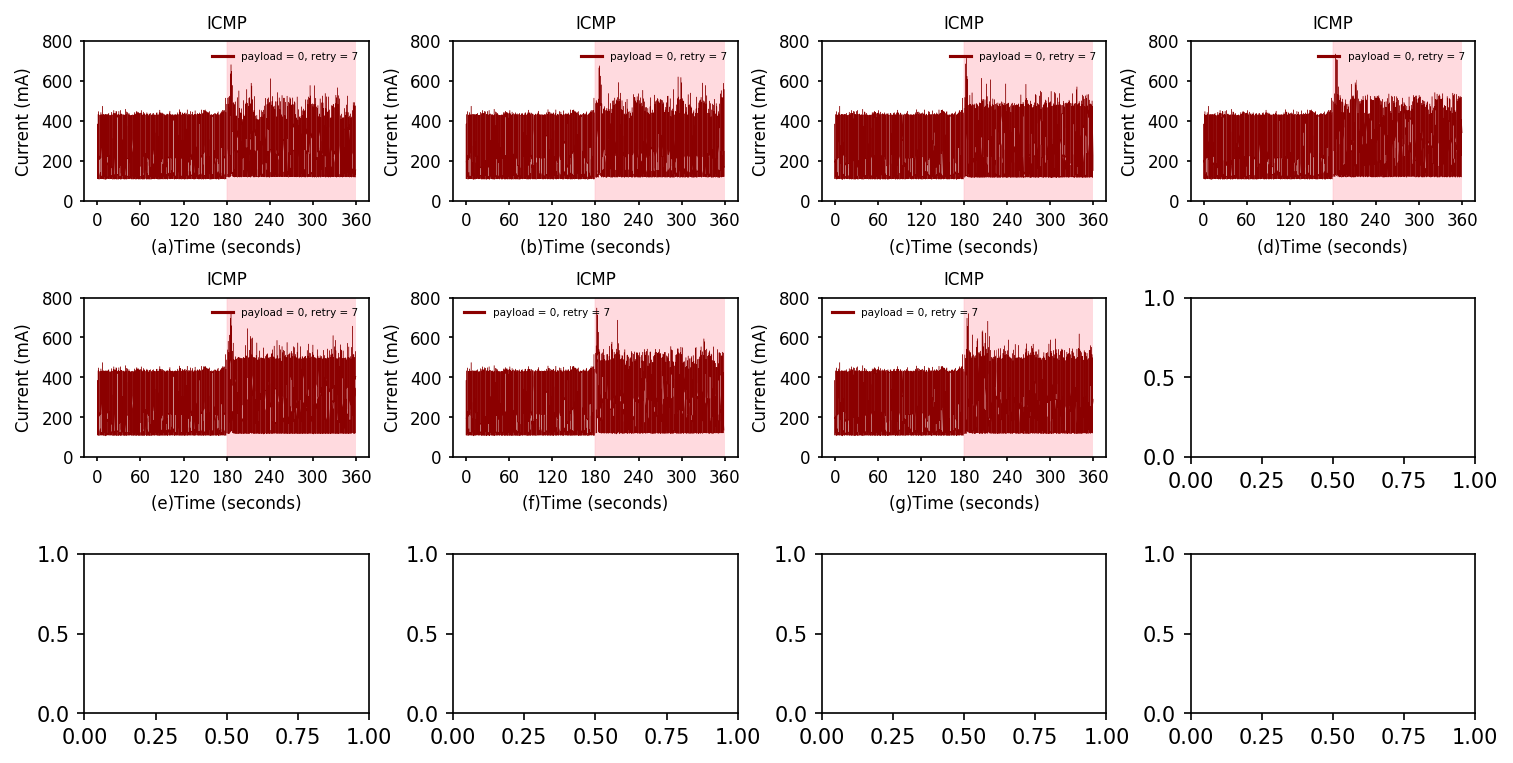

In [7]:
scen1_line  = mlines.Line2D([], [], color='darkred',  linestyle='-', label='payload = 0, retry = 7')
scen2_line  = mlines.Line2D([], [], color='darkblue', linestyle='-', label='payload = 0, retry = 1')
scen3_line  = mlines.Line2D([], [], color='darkgreen',linestyle='-', label='payload = 1400B, retry = 1')
scen4_line  = mlines.Line2D([], [], color='black',    linestyle='-', label='payload = 1400B, retry = 7')
scen_legend = [scen1_line, scen2_line, scen3_line, scen4_line]
line_color  = ['darkred','darkblue','darkgreen','black']
graph_rows       = 3
graph_cols       = 4
scenarios    = ['scen1','scen2','scen3','scen4']

n=0
p=0
i=0
k=97
m=0
fig,axes       = plt.subplots(nrows=graph_rows, ncols=graph_cols, dpi=150, figsize=(10,5))
graph_title      = ["ICMP","SYN","UDP"]
device        = 'a'
axes_list      = [item for sublist in axes for item in sublist] 
file_path      = '/home/btushir/Desktop/smarthome_ddos/%s/power/%sidle.txt'%(device,device)
df1            = pd.read_csv(file_path,sep='\t',names=['index','timeSec','nanosecond','dontcare','voltageVolt','milliampCurrent'])
minimum_time   = df1.timeSec.min()   
df1['timeSec'] = df1['timeSec'] - minimum_time 

attack_ths  = [0.5,1,2,4,6,8,10]
for attack_type in ['icmp']:
    a =[]
    b =[]
    z =[]
    for scenario in ['scen1']:
        a=[]
        b=[]
        z=[]
        
        for attack_th in attack_ths:
            #file_loc2      = '/home/btushir/Desktop/%s/%s/%s%s%sp0.txt'%(device,scenario,device,attack_type,attack_th)
            ax = axes_list.pop(0) 

            file_loc2      = '/home/btushir/Desktop/smarthome_ddos/%s/power/%s/%s%s%sp9.txt'%(device,scenario,device,attack_type,attack_th)
            df2            = pd.read_csv(file_loc2,sep='\t',names=['index','timeSec','nanosecond','dontcare','voltageVolt','milliampCurrent'])
            minimum_time   = df2.timeSec.min()   
            df2['timeSec'] = df2['timeSec'] - minimum_time
            df2['timeSec'] = df2['timeSec'] + 180        

            df     = pd.concat([df1,df2],ignore_index=True,names=['index','timeSec','nanosecond','dontcare','voltageVolt','milliampCurrent'])
            ax.plot(df['timeSec'], df['milliampCurrent'], linestyle= '-', color= line_color[i], linewidth=.2)
            ax.axvline(x=180, linewidth=.2, color='lightpink')
            ax.axvspan(180,360, facecolor='lightpink', alpha=0.5)

            ax.set_xlabel ('('+chr(k)+')'+'Time (seconds)', fontsize=8)           
            ax.set_ylabel('Current (mA)', fontsize=8)
            ax.set_title(graph_title[n], fontsize=8)
            ax.tick_params(right=False, top=False, labelsize=8,colors='k', length=2)  #primary y and x
            ax.set_yticks(np.arange(0,1000, step = 200), ) # primary y axis (bandwidth)
            ax.set_xticks(np.arange(0,361, step = 60))
            m=m+1
            k=k+1
            ax.legend(handles=[scen_legend[p]],ncol=1, borderpad= .5,fontsize = '5', frameon=False,numpoints=1)
    
    
    p =p+1
    i =i+1                                  #increment line style and colour array
    k =k+1
    n=n+1

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=.7)
#plt.show()
#plt.savefig('nestPower.eps',bbox_inches='tight') #bbox_inches='tight' : remove white spaces       

# Convert to CSV

In [13]:
!python /home/ydalal/Desktop/graphs/1scatter_final/1alexa/yo_final/10ms_final/convert_csv.py

tshark -r /home/ydalal/media/bhagyashri/a/a_tcp_filter_udp_filter/out/scen3/audp0.5out0.pcap -T fields -e _ws.col.Retry -e frame.time_relative -e ip.src -e ip.dst -E header=y -E separator=/t >/home/ydalal/media/bhagyashri/a/a_tcp_filter_udp_filter/out/scen3/csv1/audp0.5out0.csv
tshark -r /home/ydalal/media/bhagyashri/a/a_tcp_filter_udp_filter/out/scen3/audp0.5out1.pcap -T fields -e _ws.col.Retry -e frame.time_relative -e ip.src -e ip.dst -E header=y -E separator=/t >/home/ydalal/media/bhagyashri/a/a_tcp_filter_udp_filter/out/scen3/csv1/audp0.5out1.csv
tshark -r /home/ydalal/media/bhagyashri/a/a_tcp_filter_udp_filter/out/scen3/audp0.5out2.pcap -T fields -e _ws.col.Retry -e frame.time_relative -e ip.src -e ip.dst -E header=y -E separator=/t >/home/ydalal/media/bhagyashri/a/a_tcp_filter_udp_filter/out/scen3/csv1/audp0.5out2.csv
tshark -r /home/ydalal/media/bhagyashri/a/a_tcp_filter_udp_filter/out/scen3/audp0.5out3.pcap -T fields -e _ws.col.Retry -e frame.time_relative -e ip.src -e ip.dst 

tshark -r /home/ydalal/media/bhagyashri/a/a_tcp_filter_udp_filter/out/scen3/audp10out0.pcap -T fields -e _ws.col.Retry -e frame.time_relative -e ip.src -e ip.dst -E header=y -E separator=/t >/home/ydalal/media/bhagyashri/a/a_tcp_filter_udp_filter/out/scen3/csv1/audp10out0.csv
tshark -r /home/ydalal/media/bhagyashri/a/a_tcp_filter_udp_filter/out/scen3/audp10out1.pcap -T fields -e _ws.col.Retry -e frame.time_relative -e ip.src -e ip.dst -E header=y -E separator=/t >/home/ydalal/media/bhagyashri/a/a_tcp_filter_udp_filter/out/scen3/csv1/audp10out1.csv
tshark -r /home/ydalal/media/bhagyashri/a/a_tcp_filter_udp_filter/out/scen3/audp10out2.pcap -T fields -e _ws.col.Retry -e frame.time_relative -e ip.src -e ip.dst -E header=y -E separator=/t >/home/ydalal/media/bhagyashri/a/a_tcp_filter_udp_filter/out/scen3/csv1/audp10out2.csv
tshark -r /home/ydalal/media/bhagyashri/a/a_tcp_filter_udp_filter/out/scen3/audp10out3.pcap -T fields -e _ws.col.Retry -e frame.time_relative -e ip.src -e ip.dst -E head

# Practice

In [29]:
file_loc2 = '/home/ydalal/media/bhagyashri/a/a_tcp_filter_udp_filter/power/scen1/aicmp0.5p0.txt'
df3 = pd.read_csv(file_loc2,sep='\t',names=['index','timeSec','nanosecond','dontcare','voltageVolt','milliampCurrent'], low_memory=False)
df3['power'] = df3['voltageVolt'] * df3['milliampCurrent'] 
df3['nanosecond'] = df3['nanosecond']/1000000000
df3['timeSecAbs'] =  df3['timeSec'] - df3.timeSec.min()
df3['nanosecond']   = df3['timeSecAbs'] + df3['nanosecond']
# convert datatype
df3['nanosecond'] = df3['nanosecond'].astype(str)
df3['nanosecond']=df3['nanosecond'].apply(lambda x: keep_digits(x,3))

# one row is mean of 10 ms
df_ms_attack = df3[['nanosecond','power']].groupby(by=['nanosecond']).mean().reset_index()
df_ms_attack.columns = ['nanosecond','power_attack']
#print (df_ms_attack.shape)
# df_ms_attack.head()

In [31]:
df = pd.read_csv('/home/ydalal/media/bhagyashri/a/a_tcp_filter_udp_filter/out/scen1/csv1/aicmp0.5out0.csv',sep='\t',names=['packets','time','ipSrc','ipDst'],low_memory=False)
# # to drop first row
df.drop(df.index[0], inplace=True)
df_ms_rate = df.copy(deep=True)
## to find rate for per 10 ms 
df_ms_rate['time'] = df_ms_rate['time'].astype(str)
df_ms_rate['time'] = df_ms_rate['time'].apply(lambda x: keep_digits(x,3))  # 3: 10ms,4 : 1ms
df_ms_rate   = df_ms_rate[['time','ipDst']].groupby(by=['time'])['ipDst'].apply(lambda x:x[x.str.contains('192.168.1.245', na=False)].count()).to_frame('attack_rate').reset_index()

# df_ms_rate.head()

In [32]:
df_ms_merged1 = pd.merge(df_ms_attack,df_ms_rate,left_on=['nanosecond'],
                                                            right_on=['time'],
                                                            how='inner')
# df_ms_merged1.head()

In [33]:
max_corr = 0
corr_arr =[]
shift_arr = []
idle_power = 556.827584196
N = 1.5

#df_ms_merged.drop(df_ms_merged.index[0:1500], inplace=True)
for k in range (0,5,1):
    df_ms_merged = df_ms_merged1.copy(deep=True)
    df_ms_merged['attack_rate'] = df_ms_merged['attack_rate'].shift(k)
    df_ms_merged = df_ms_merged.dropna()
    df_ms_merged['nanosecond'] =  df_ms_merged['nanosecond'] - df_ms_merged.nanosecond.min()
    df_ms_merged['time'] =  df_ms_merged['time'] - df_ms_merged.time.min()
    
    df_ms_merged['one_half_sec'] = df_ms_merged.nanosecond//N
    df_one_half_sec = df_ms_merged.groupby(df_ms_merged.nanosecond//N,as_index=False).agg({'one_half_sec':'mean','time':'mean','nanosecond': 'mean','power_attack': 'mean','attack_rate':'sum'})
    

    corr = stats.pearsonr(df_one_half_sec['attack_rate'],df_one_half_sec['power_attack'])[0]
    print ("corr for shift" + " "+ str(k)+" is: " +str(corr))
    corr_arr.append((corr,k))

print "max corr",np.amax(corr_arr, axis=0)   
x=np.argmax(corr_arr, axis=0)
corr_arr[x[0]]
# df_ms_merged
# df_one_half_sec

corr for shift 0 is: 0.06664619031763404
corr for shift 1 is: 0.06967213277618275
corr for shift 2 is: 0.06229370826364829
corr for shift 3 is: 0.0636806437690493
corr for shift 4 is: 0.05946045050419743
max corr [0.06967213 4.        ]


(0.06967213277618275, 1)

In [84]:
df = df_ms_merged1.copy(deep=True)
df
df.head(100)

nanosecond  power_attack  time  attack_rate
0         0.55   1424.443448  0.55            3
1         0.56   1162.924536  0.56            5
2         0.57    669.617583  0.57           10
3         0.58   1030.316308  0.58            4
4         0.59    843.889628  0.59            3
5         0.60   1715.748918  0.60            3
6         0.61   1506.587121  0.61            2
7         0.62    960.909918  0.62            4
8         0.63   1008.777456  0.63            4
9         0.64    916.502440  0.64            3
10        0.66   1469.699118  0.66            8
11        0.67   1424.764153  0.67            4
12        0.68   1026.030597  0.68            2
13        0.69   1114.478864  0.69            4
14        0.70    863.994305  0.70            3
15        0.71    883.129156  0.71            2
16        0.72   1216.267122  0.72            3
17        0.74   1147.806321  0.74            6
18        0.75    922.509902  0.75            1
19        0.76    833.155809  0.76            4
20        0.77    878.912462  0.77            2
21        0.78   1770.834442  0.78            2
22        0.79   1346.648834  0.79            2
23        0.80   1151.660666  0.80            4
24        0.82   1037.456114  0.82            9
25        0.83    875.622220  0.83            5
26        0.84   1655.433373  0.84            2
27        0.85   1480.702727  0.85            4
28        0.86    918.938265  0.86            4
29        0.87   1022.091062  0.87            3
30        0.88    908.116928  0.88            2
31        0.89    886.930925  0.89            8
32        0.90   1181.738761  0.90            7
33        0.91   1490.334517  0.91            2
34        0.92   1238.310151  0.92            2
35        0.93   1177.007969  0.93            3
36        0.94    776.243828  0.94            2
37        0.95   1025.186567  0.95            6
38        0.96    981.387526  0.96            3
39        0.97   1799.253523  0.97            4
40        0.98   1416.310944  0.98           11
41        0.99    843.618785  0.99            2
42        1.02   1722.768630  1.02            4
43        1.03   1313.911725  1.03            3
44        1.05   1051.534104  1.05           13
45        1.06   1081.041282  1.06            3
46        1.09   1491.329164  1.09            8
47        1.10    931.424994  1.10            4
48        1.11   1049.309749  1.11            3
49        1.12    967.730282  1.12            2
50        1.14   1654.442487  1.14            4
51        1.15   1572.290302  1.15            1
52        1.16   1033.372579  1.16            3
53        1.17   1122.815384  1.17            2
54        1.18    718.080500  1.18            2
55        1.19    849.824643  1.19            2
56        1.20    907.972069  1.20            2
57        1.22   1305.133678  1.22            7
58        1.23   1622.104640  1.23            7
59        1.24   1238.487628  1.24            3
60        1.25   1199.622732  1.25            3
61        1.27   1285.824003  1.27            4
62        1.28    870.243658  1.28            3
63        1.30   1036.928320  1.30            6
64        1.31    953.364094  1.31            2
65        1.32   1757.146613  1.32            2
66        1.33   1451.396244  1.33            2
67        1.34    913.770213  1.34            4
68        1.35    999.297233  1.35            3
69        1.36   1081.372851  1.36            2
70        1.38   1196.685642  1.38            5
71        1.39   1920.934445  1.39            1
72        1.40   1200.500479  1.40            4
73        1.41   1214.085216  1.41            1
74        1.42    778.482754  1.42            3
75        1.43   1006.963100  1.43            3
76        1.44    989.008294  1.44            3
77        1.45   2021.878775  1.45           10
78        1.46   1287.659001  1.46            7
79        1.47    947.239238  1.47            4
80        1.48    993.072229  1.48            8
81        1.49   1364.762085  1.49            7
82        1.50   157

In [101]:
N = 1.5
# print df_p.nanosecond // N
df['one_half_sec'] = df.nanosecond//N
df_one_half_sec = df.groupby(df.nanosecond//N,as_index=False).agg({'one_half_sec':'mean','time':'mean','nanosecond': 'mean','power_attack': 'mean','attack_rate':'sum'})

df_one_half_sec
# print df_p1.head()


one_half_sec  nanosecond  attack_rate  power_attack        time
0             0.0    1.015244          327   1172.050053    1.015244
1             1.0    2.234480          475   1320.102884    2.234480
2             2.0    3.753254          438   1758.423352    3.753254
3             3.0    5.260076          476   1527.626613    5.260076
4             4.0    6.751148          450   1171.001602    6.751148
5             5.0    8.241181          463   1199.561331    8.241181
6             6.0    9.747829          462   1175.789792    9.747829
7             7.0   11.259904          440   1171.932542   11.259904
8             8.0   12.771339          511   1174.168761   12.771339
9             9.0   14.258790          391   1205.898786   14.258790
10           10.0   15.754186          472   1184.943369   15.754186
11           11.0   17.248968          453   1187.509099   17.248968
12           12.0   18.763140          452   1189.361952   18.763140
13           13.0   20.250744          482   1188.987971   20.250744
14           14.0   21.721077          515   1174.562314   21.721077
15           15.0   23.261825          453   1161.235339   23.261825
16           16.0   24.731746          447   1194.690788   24.731746
17           17.0   26.240391          441   1174.351005   26.240391
18           18.0   27.752764          441   1194.326334   27.752764
19           19.0   29.244262          441   1190.922032   29.244262
20           20.0   30.761382          450   1267.452267   30.761382
21           21.0   32.240783          417   1383.345465   32.240783
22           22.0   33.736260          470   1215.604413   33.736260
23           23.0   35.273386          437   1162.167785   35.273386
24           24.0   36.721795          448   1163.378398   36.721795
25           25.0   38.237879          443   1184.044431   38.237879
26           26.0   39.738049          417   1186.176359   39.738049
27           27.0   41.232963          493   1167.819987   41.232963
28           28.0   42.731440          449   1155.332875   42.731440
29           29.0   44.241679          415   1207.606814   44.241679
30           30.0   45.729837          439   1179.779304   45.729837
31           31.0   47.278197          496   1173.494166   47.278197
32           32.0   48.747049          471   1204.735735   48.747049
33           33.0   50.232803          477   1163.390446   50.232803
34           34.0   51.754252          473   1174.756798   51.754252
35           35.0   53.220937          463   1176.290750   53.220937
36           36.0   54.739833          454   1187.000004   54.739833
37           37.0   56.281750          436   1204.192693   56.281750
38           38.0   57.748231          422   1183.670958   57.748231
39           39.0   59.282101          400   1135.119168   59.282101
40           40.0   60.759237          443   1187.779824   60.759237
41           41.0   62.243636          439   1182.012691   62.243636
42           42.0   63.736842          469   1188.313290   63.736842
43           43.0   65.264228          407   1152.397628   65.264228
44           44.0   66.743712          445   1167.198488   66.743712
45           45.0   68.230952          449   1160.285846   68.230952
46           46.0   69.731094          457   1185.379019   69.731094
47           47.0   71.242121          432   1176.789563   71.242121
48           48.0   72.760082          483   1177.205705   72.760082
49           49.0   74.288430          415   1174.951586   74.288430
50           50.0   75.736985          519   1187.377365   75.736985
51           51.0   77.229274          422   1200.535113   77.229274
52           52.0   78.695932          458   1172.873116   78.695932
53           53.0   80.278092          479   1177.852811   80.278092
54           54.0   81.741705          460   1173.858422   81.741705
55           55.0   83.242190          469   1189.139465   83.242190
56           56.0   84.751575          420   1168.709284   84.751575
57 

In [40]:
print df_ms_merged1.index//N

Float64Index([   0.0,    0.0,    1.0,    2.0,    2.0,    3.0,    4.0,    4.0,
                 5.0,    6.0,
              ...
              1182.0, 1183.0, 1184.0, 1184.0, 1185.0, 1186.0, 1186.0, 1187.0,
              1188.0, 1188.0],
             dtype='float64', length=1784)


In [25]:
s = pd.Series(range(50))
print s

0      0
1      1
2      2
3      3
4      4
5      5
6      6
7      7
8      8
9      9
10    10
11    11
12    12
13    13
14    14
15    15
16    16
17    17
18    18
19    19
20    20
21    21
22    22
23    23
24    24
25    25
26    26
27    27
28    28
29    29
30    30
31    31
32    32
33    33
34    34
35    35
36    36
37    37
38    38
39    39
40    40
41    41
42    42
43    43
44    44
45    45
46    46
47    47
48    48
49    49
dtype: int64


In [26]:
N = 5
s.groupby(s.index // N).sum()

0     10
1     35
2     60
3     85
4    110
5    135
6    160
7    185
8    210
9    235
dtype: int64

In [30]:
print s.index//N

Int64Index([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4,
            4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 8, 8, 8, 8,
            8, 9, 9, 9, 9, 9],
           dtype='int64')


In [19]:
max_corr = 0
corr_arr =[]
shift_arr = []
idle_power = 556.827584196
frames = []
rows = []

#df_ms_merged.drop(df_ms_merged.index[0:1500], inplace=True)
for k in range (0,500,197):
    df_ms_merged = df_ms_merged1.copy(deep=True)
    df_ms_merged['attack_rate'] = df_ms_merged['attack_rate'].shift(k)
    df_ms_merged = df_ms_merged.dropna()
    df_ms_merged['nanosecond'] =  df_ms_merged['nanosecond'] - df_ms_merged.nanosecond.min()
    df_ms_merged['time'] =  df_ms_merged['time'] - df_ms_merged.time.min()

    df_500ms_power = df_ms_merged[['nanosecond', 'power_attack']].copy(deep=True)
    df_500ms_power['nanosecond'] = df_500ms_power['nanosecond'].astype(str)
    df_500ms_power['nanosecond'] =  df_500ms_power['nanosecond'].apply(lambda x: keep_digits(x,1))

    for i in df_500ms_power.nanosecond.unique():
        df = df_500ms_power[df_500ms_power['nanosecond']== i]
        center_index = df.shape[0]/2
        if center_index == 0:
            center_index=1

        power_mean_per_500ms = df[:center_index]['power_attack'].mean()
        frames.append([i,power_mean_per_500ms])

        power_mean_per_500ms = df[center_index:]['power_attack'].mean()
        frames.append([i+0.500,power_mean_per_500ms])

    df_500ms_power = pd.DataFrame(frames,columns=['nanosecond','power_attack'])
    df_500ms_power = df_500ms_power.dropna()
    df_500ms_power['power_perc_chng'] = ((df_500ms_power['power_attack'] - idle_power)/idle_power)*100


    df_500ms_rate = df_ms_merged[['time','attack_rate']].copy(deep=True)
    df_500ms_rate['time'] = df_500ms_rate['time'].astype(str)
    df_500ms_rate['time'] =  df_500ms_rate['time'].apply(lambda x: keep_digits(x,1))

    for i in df_500ms_rate.time.unique():
        df = df_500ms_rate[df_500ms_rate['time']==i]
        center_index = int (df.shape[0]/2)
        if center_index == 0:
            center_index=1
        rate_count_per_500ms = df[:center_index]['attack_rate'].sum()
        rows.append([i,rate_count_per_500ms])

        rate_count_per_500ms = df[center_index:]['attack_rate'].sum()
        rows.append([i+0.500,rate_count_per_500ms])

    df_500ms_rate = pd.DataFrame(rows,columns=['time','attack_rate'])

    df_500ms_merged = pd.merge(df_500ms_power,df_500ms_rate,left_on=['nanosecond'],right_on=['time'],how='inner')
    df_500ms_merged.drop(df_500ms_merged.tail(1).index,inplace=True)
    corr = stats.pearsonr(df_500ms_merged['attack_rate'],df_500ms_merged['power_attack'])[0]
    print ("corr for shift" + " "+ str(k)+" is: " +str(corr))
    corr_arr.append((corr,k))

print "max corr",np.amax(corr_arr, axis=0)   
x=np.argmax(corr_arr, axis=0)
corr_arr[x[0]]

corr for shift 0 is: 0.00314083871867679
corr for shift 197 is: 0.09003111295826077
corr for shift 394 is: 0.06160326732254929
max corr [9.0031113e-02 3.9400000e+02]


(0.09003111295826077, 197)

In [24]:
max_corr = 0
corr_arr =[]
shift_arr = []
idle_power = 556.827584196
frames = []
rows = []

df_ms_merged = df_ms_merged1.copy(deep=True)
df_ms_merged['attack_rate'] = df_ms_merged['attack_rate'].shift(5)
df_ms_merged = df_ms_merged.dropna()
df_ms_merged['nanosecond'] =  df_ms_merged['nanosecond'] - df_ms_merged.nanosecond.min()
df_ms_merged['time'] =  df_ms_merged['time'] - df_ms_merged.time.min()

df_500ms_power = df_ms_merged[['nanosecond', 'power_attack']].copy(deep=True)
df_500ms_power['nanosecond'] = df_500ms_power['nanosecond'].astype(str)
df_500ms_power['nanosecond'] =  df_500ms_power['nanosecond'].apply(lambda x: keep_digits(x,1))

for i in df_500ms_power.nanosecond.unique():
    df = df_500ms_power[df_500ms_power['nanosecond']== i]
    center_index = df.shape[0]/2
    if center_index == 0:
        center_index=1
        
    power_mean_per_500ms = df[:center_index]['power_attack'].mean()
    frames.append([i,power_mean_per_500ms])

    power_mean_per_500ms = df[center_index:]['power_attack'].mean()
    frames.append([i+0.500,power_mean_per_500ms])

df_500ms_power = pd.DataFrame(frames,columns=['nanosecond','power_attack'])
df_500ms_power = df_500ms_power.dropna()
df_500ms_power['power_perc_chng'] = ((df_500ms_power['power_attack'] - idle_power)/idle_power)*100


df_500ms_rate = df_ms_merged[['time','attack_rate']].copy(deep=True)
df_500ms_rate['time'] = df_500ms_rate['time'].astype(str)
df_500ms_rate['time'] =  df_500ms_rate['time'].apply(lambda x: keep_digits(x,1))

for i in df_500ms_rate.time.unique():
    df = df_500ms_rate[df_500ms_rate['time']==i]
    center_index = int (df.shape[0]/2)
    if center_index == 0:
        center_index=1
    rate_count_per_500ms = df[:center_index]['attack_rate'].sum()
    rows.append([i,rate_count_per_500ms])

    rate_count_per_500ms = df[center_index:]['attack_rate'].sum()
    rows.append([i+0.500,rate_count_per_500ms])

df_500ms_rate = pd.DataFrame(rows,columns=['time','attack_rate'])

df_500ms_merged = pd.merge(df_500ms_power,df_500ms_rate,left_on=['nanosecond'],right_on=['time'],how='inner')
df_500ms_merged.drop(df_500ms_merged.tail(1).index,inplace=True)
corr = stats.pearsonr(df_500ms_merged['attack_rate'],df_500ms_merged['power_attack'])[0]
print ("corr is: " +str(corr))
# df_ms_merged
# print (df_500ms_power.tail(20))
# print (df_500ms_rate.tail(20))
# print (df_500ms_merged.tail(20))

corr is: 0.1714313786356235


Text(0,0.5,'power_change')

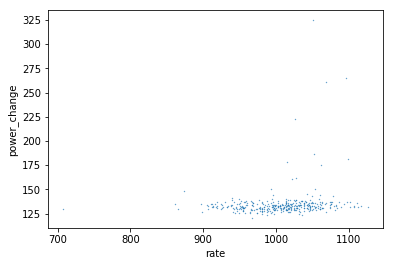

In [21]:
plt.scatter(df_500ms_merged['attack_rate'],df_500ms_merged['power_perc_chng'],s=.1)

plt.xlabel("rate")
plt.ylabel("power_change")


In [22]:
lm = linear_model.LinearRegression()
independent_variable_rate = df_500ms_merged.attack_rate.values.reshape(-1,1)
dependent_varaiable_power = df_500ms_merged.power_perc_chng.values.reshape(-1,1)
lm.fit(independent_variable_rate,dependent_varaiable_power)
print (lm.coef_)
print (lm.intercept_)

power_pred = lm.predict(independent_variable_rate)


[[0.05522258]]
[79.32499375]


In [23]:
print(math.sqrt(metrics.mean_squared_error(dependent_varaiable_power, power_pred)))

15.9625675224


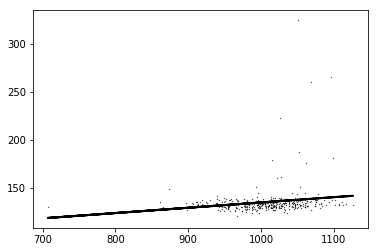

In [30]:
plt.scatter(df_500ms_merged['attack_rate'],df_500ms_merged['power_perc_chng'],s=.1, color='black')
plt.plot(df_500ms_merged['attack_rate'], power_pred, color='black', linewidth=2)
plt.show()